`TTbarResCoffea` Notebook to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
This module must be run twice: 
   1. Make the mistag rate in the "anti-tag and probe" selection 
and the expectation in the signal region from MC,
   1. Applies that mistag rate and the mod-mass procedure to the single-tag selection. 

These are all done in bins of
b-tag categories (0, 1, $\ge 2$) and rapidity ($|y| \le 1.0$, $|y| > 1.0$).
The signal region is two top-tagged jets. 
The background estimate is the single-tag selection weighted by the mistag rate from the
"anti-tag and probe" region, with the mass of the weighted jet set to a random
value from QCD MC in the 1-ttag region. 


The preselection is:
- AK4-based $H_{T} > 1100$ GeV (to be on the trigger plateau). 
- $\ge 2$ AK8 jets with AK8 $p_{T} > 400$ GeV and $|y| < 2.5$, loose jet ID applied from matched AK4 jets

The 1-tag selection adds:
- $\ge 1$ AK8 jet with top tagging applied to randomly-assigned tag jet. 


The anti-tag selection is disjoint from the 1-tag selection:
- $\ge 1$ AK8 jet with top tagging VETO applied to randomly-assigned tag jet. 


The 2-tag selection is:
- $\ge 2$ AK8 jets with top tagging applied to both leading jets. 


The ttbar candidate mass assumes the two leading top-tagged jets are the top quarks. 


In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from coffea import util
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

In [2]:
xrootdstr1 = 'root://cmseos.fnal.gov//'
xrootdstr2 = 'root://cmsxrootd.fnal.gov//'
xrootdstr3 = 'root://cmsxrootd-site.fnal.gov/'

In [3]:
qcdfilename = 'QCD.txt'
with open(qcdfilename) as f:
    qcdfiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [4]:
ttbarfilename = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8.txt'
with open(ttbarfilename) as f:
    ttbarfiles = [xrootdstr1 + s.strip() for s in f.readlines()]

In [5]:
jetdatafilename = 'JetHT_Data.txt'
with open(jetdatafilename) as f:
    #jetdatafiles = [xrootdstr2 + s.strip() for s in f.readlines() if "/store/data/Run2017" in s]
    jetdatafiles = [xrootdstr2 + s.strip() for s in f.readlines()[::3]] # Every third datafile

In [6]:
#print(jetdatafiles[2]) # Test to see if correct files are collected

In [7]:
from columnservice.client import ColumnClient
cc = ColumnClient("coffea-dask.fnal.gov")
client = cc.get_dask()

In [8]:
prng = RandomState(1234567890)

In [9]:
"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class TTbarResProcessor(processor.ProcessorABC):
    def __init__(self, htCut=1100., minMSD=105., maxMSD=210., tau32Cut=0.7, ak8PtMin=400., bdisc=0.7,
                writePredDist=True,isData=True,year=2019, UseLookUpTables=False,
                lu = None):
        
        #self.prng = RandomState(1234567890)
        self.htCut = htCut
        self.minMSD = minMSD
        self.maxMSD = maxMSD
        self.tau32Cut = tau32Cut
        self.ak8PtMin = ak8PtMin
        self.bdisc = bdisc
        self.writePredDist = writePredDist
        self.writeHistFile = True
        self.isData = isData
        self.year=year
        self.UseLookUpTables = UseLookUpTables
        self.lu = lu # Look Up Tables
        
        self.ttagcats = ["At","at", "0t", "1t", "2t"] #anti-tag+probe, anti-tag, 0, 1, >=2 ttags
        self.btagcats = ["0b", "1b", "2b"]   # 0, 1, >=2 btags
        self.ycats = ['cen', 'fwd']          # Central and forward
        # Combine categories like "0bcen", "0bfwd", etc:
        self.anacats = [ t+b+y for t,b,y in itertools.product( self.ttagcats, self.btagcats, self.ycats) ]
        print(self.anacats)
        
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        cats_axis = hist.Cat("anacat", "Analysis Category")
        
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 50, 0, 5000)
        ttbarmass_axis = hist.Bin("ttbarmass", r"$m_{t\bar{t}}$ [GeV]", 50, 0, 5000)
        jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", 50, -4, 4)
        jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -3.14, 3.14)
        jety_axis = hist.Bin("jety", r"Jet $y$", 50, -3, 3)
        jetdy_axis = hist.Bin("jetdy", r"Jet $\Delta y$", 50, 0, 3)
        jetp_axis = hist.Bin("jetp", r"Jet $p$ [GeV]", 50, 0, 5000)
        
        subjetmass_axis = hist.Bin("subjetmass", r"SubJet $m$ [GeV]", 50, 0, 500)
        subjetpt_axis = hist.Bin("subjetpt", r"SubJet $p_{T}$ [GeV]", 50, 0, 2000)
        subjeteta_axis = hist.Bin("subjeteta", r"SubJet $\eta$", 50, -4, 4)
        subjetphi_axis = hist.Bin("subjetphi", r"SubJet $\phi$", 50, -3.14, 3.14)

        self._accumulator = processor.dict_accumulator({
            'ttbarmass': hist.Hist("Counts", dataset_axis, cats_axis, ttbarmass_axis),
            'jetmass':   hist.Hist("Counts", dataset_axis, cats_axis, jetmass_axis),
            'jetpt':     hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'jeteta':    hist.Hist("Counts", dataset_axis, cats_axis, jeteta_axis),
            'probept':   hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'probep':    hist.Hist("Counts", dataset_axis, cats_axis, jetp_axis),

            'jetphi':    hist.Hist("Counts", dataset_axis, cats_axis, jetphi_axis),
            'jety':      hist.Hist("Counts", dataset_axis, cats_axis, jety_axis),
            'jetdy':     hist.Hist("Counts", dataset_axis, cats_axis, jetdy_axis),
            
            'subjetmass':   hist.Hist("Counts", dataset_axis, cats_axis, subjetmass_axis),
            'subjetpt':     hist.Hist("Counts", dataset_axis, cats_axis, subjetpt_axis),
            'subjeteta':    hist.Hist("Counts", dataset_axis, cats_axis, subjeteta_axis),
            'subjetphi':    hist.Hist("Counts", dataset_axis, cats_axis, subjetphi_axis),
            
            'numerator':   hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'denominator': hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            
            'SumW':  processor.column_accumulator(np.array([])),
            'SumW2': processor.column_accumulator(np.array([])),
            
            'cutflow': processor.defaultdict_accumulator(int),
            
        })

            
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        
        output = self.accumulator.identity()
        
        #dataset = events.metadata['dataset']
        dataset = df['dataset']
        FatJets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            msoftdrop=df['FatJet_msoftdrop'],
            jetId=df['FatJet_jetId'],
            tau1=df['FatJet_tau1'],
            tau2=df['FatJet_tau2'],
            tau3=df['FatJet_tau3'],
            tau4=df['FatJet_tau4'],
            n3b1=df['FatJet_n3b1'],
            btagDeepB=df['FatJet_btagDeepB'],
            deepTag_TvsQCD=df['FatJet_deepTag_TvsQCD'],
            deepTagMD_TvsQCD=df['FatJet_deepTagMD_TvsQCD']
            )
        # ---- Define Jets ---- #
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nSubJet'],
            pt=df['Jet_pt'],
            eta=df['Jet_eta'],
            phi=df['Jet_phi'],
            mass=df['Jet_mass']
            )
        
        # ---- Get event weights from dataset ---- #
        if 'JetHT' in dataset: # If data is used...
            evtweights = np.ones(FatJets.size) # set all "data weights" to one
        else: # if Monte Carlo dataset is used...
            evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        
        # ---- Show all events ---- #
        output['cutflow']['all events'] += FatJets.size        
        
        # ---- Apply HT Cut ---- #
        hT = Jets.pt.sum()
        passhT = (hT > self.htCut)
        evtweights = evtweights[passhT]
        FatJets = FatJets[passhT]
        
        # ---- FatJets Info ---- #
        oneFatJet = (FatJets.counts >= 1) # at least one fat jet
        FatJets = FatJets[oneFatJet]
        evtweights = evtweights[oneFatJet]
        output['cutflow']['one FatJets'] += oneFatJet.sum()
        
        twoFatJets = (FatJets.counts >= 2)
        FatJets = FatJets[twoFatJets]
        evtweights = evtweights[twoFatJets]
        output['cutflow']['two FatJets'] += twoFatJets.sum()

        jet_id = (FatJets.jetId > 0)
        
        FatJets = FatJets[jet_id]
        output['cutflow']['jet id'] += jet_id.any().sum()
        
        jetkincut_index = (FatJets.pt > self.ak8PtMin) & (np.abs(FatJets.eta) < 2.5) # eta cut here
        FatJets = FatJets[ jetkincut_index ]
        output['cutflow']['jet kin'] += jetkincut_index.any().sum()

        twoFatJetsKin = (FatJets.counts >= 2) # Whats the difference from twoFatJets ?
        FatJets = FatJets[twoFatJetsKin]
        evtweights = evtweights[twoFatJetsKin]
        output['cutflow']['two FatJets and jet kin'] += twoFatJetsKin.sum()
        
        FatJets = FatJets[:,0:2]
        
        # ---- Randomly Select AK8 Jet as TTbar Candidate --- #

        index = JaggedArray.fromcounts(np.ones(len(FatJets), dtype='i'), prng.randint(2, size=len(FatJets)))
        jet0 = FatJets[index]
        jet1 = FatJets[1 - index]
        
        #print("index size = ", index.size)
        #print(index.tolist())
        #print()
        
        ttbarcands = jet0.cross(jet1) #FatJets[:,0:2].distincts()
        
        # ---- Look for more than one TTbar candidate and re-broadcast releveant arrays  ---- #
        oneTTbar = (ttbarcands.counts >= 1)
        output['cutflow']['>= one oneTTbar'] += oneTTbar.sum()
        ttbarcands = ttbarcands[oneTTbar]
        evtweights = evtweights[oneTTbar]
        FatJets = FatJets[oneTTbar]
         
        # ---- Apply Delta Phi Cut ---- #
        dPhiCut = (ttbarcands.i0.p4.delta_phi(ttbarcands.i1.p4) > 2.1).flatten()
        output['cutflow']['dPhi > 2.1'] += dPhiCut.sum()
        ttbarcands = ttbarcands[dPhiCut]
        evtweights = evtweights[dPhiCut]
        FatJets = FatJets[dPhiCut] 
        
        
        # ---- Get Analysis Categories ---- # 
        # ---- They are (central, forward)   cross   (0b,1b,>=2b) ---- #
        cen = np.abs(ttbarcands.i0.p4.rapidity - ttbarcands.i1.p4.rapidity) < 1.0
        fwd = (~cen)
        tau32_i0 = np.where(ttbarcands.i0.tau2>0,ttbarcands.i0.tau3/ttbarcands.i0.tau2, 0 )
        tau32_i1 = np.where(ttbarcands.i1.tau2>0,ttbarcands.i1.tau3/ttbarcands.i1.tau2, 0 )
        taucut_i0 = tau32_i0 < self.tau32Cut
        taucut_i1 = tau32_i1 < self.tau32Cut
        mcut_i0 = (self.minMSD < ttbarcands.i0.msoftdrop) & (ttbarcands.i0.msoftdrop < self.maxMSD) 
        mcut_i1 = (self.minMSD < ttbarcands.i1.msoftdrop) & (ttbarcands.i1.msoftdrop < self.maxMSD) 

        ttag_i0 = (taucut_i0) & (mcut_i0)
        ttag_i1 = (taucut_i1) & (mcut_i1)
        antitag = (~taucut_i0) & (mcut_i0) #Probe will always be ttbarcands.i1
        
        ttag0 = (~ttag_i0) & (~ttag_i1)
        ttag1 = ttag_i0 ^ ttag_i1
        ttag2 = ttag_i0 & ttag_i1

        btag_i0 = (ttbarcands.i0.btagDeepB > self.bdisc)
        btag_i1 = (ttbarcands.i1.btagDeepB > self.bdisc)
        
        btag0 = (~btag_i0) & (~btag_i1)
        btag1 = btag_i0 ^ btag_i1
        btag2 = btag_i0 & btag_i1
        
        antitag_probe = np.logical_and(antitag, ttag_i1) #Found an antitag and ttagged probe pair for mistag rate
        
        regs = [cen,fwd]
        btags = [btag0,btag1,btag2]
        ttags = [antitag_probe,antitag,ttag0,ttag1,ttag2]
        cats = [ (t&b&y).flatten() for t,b,y in itertools.product( ttags, btags, regs) ]
        labels_and_categories = dict(zip( self.anacats, cats ))
        
        ttbarmass = ttbarcands.p4.sum().mass.flatten()
        jetpt = ttbarcands.i1.pt.flatten()
        jeteta = ttbarcands.i1.eta.flatten()
        jetphi = ttbarcands.i1.phi.flatten()
        jety = ttbarcands.i1.p4.rapidity.flatten()
        jetdy = np.abs(ttbarcands.i0.p4.rapidity.flatten() - ttbarcands.i1.p4.rapidity.flatten())
        
        #print("jetpt both = ", ttbarcands.pt.flatten())
        #print("jetpt control = ", ttbarcands.i0.pt.flatten())
        #print("jetpt probe = ", ttbarcands.i1.pt.flatten())
        #print()
        
        weights = evtweights.flatten()
        #weights[weights < 0] = 0
        
        # ---- Define the SumW2 for MC Datasets ---- #
        #output['cutflow']['sumw'] += np.sum(weights)
        #output['cutflow']['sumw2'] += np.sum(weights**2)
        # ---- Define Momentum p of probe jet as the Mistag Rate variable; M(p) ---- #
        # ---- Transverse Momentum pT can also be used instead; M(pT) ---- #
        pT = ttbarcands.i1.pt.flatten()
        eta = ttbarcands.i1.eta.flatten()
        pz = np.sinh(eta)*pT
        p = np.absolute(np.sqrt(pT**2 + pz**2))
        
        # ---- Define the Numerator and Denominator for Mistag Rate ---- #
        numerator = np.where(antitag_probe, pT, -9999) # If no antitag and tagged probe, move event to useless bin
        denominator = np.where(antitag, pT, -9999) # If no antitag, move event to useless bin
        
        df = pd.DataFrame({"transverse momentum":pT}) # Used for finding values in LookUp Tables
        
        for ilabel,icat in labels_and_categories.items():
            ### ------------------------------------ Mistag Scaling ------------------------------------ ###
            if self.UseLookUpTables == True:
                file_df = self.lu['at' + str(ilabel[2:])] # get mistag (lookup) filename for 'at'
                bin_widths = file_df['pT'].values # collect bins as written in .csv file
                mtr = file_df['M(pT)'].values # collect mistag rate as function of p as written in file
                wgts = mtr # Define weights based on mistag rates
                BinKeys = np.arange(bin_widths.size) # Use as label for BinNumber column in the new dataframe
                print('bin_widths = \n', bin_widths)
                print('\n pT = \n', pT)
                print('\n BinKeys = \n', BinKeys)
# for M('p')                Bins = np.arange(bin_widths.size+1)*100. # Temporary definition of bins as floats
# for M('p')               P = np.where(p>5000., 5000., p) # Avoids momentum larger than the allowed bin size; caps the momentum
                Bins = pd.interval_range(start=0, periods=50, freq=100, closed='left') # Recreate the momentum bins from file_df as something readable for pd.cut()
                #PT = np.where(pT>2000., 2000., pT)
                print('\n bin_widths -> Readable Bins = \n', Bins)
        
                df['BinWidth'] = pd.cut(pT, bins=Bins) # new dataframe column
                df['BinNumber'] = pd.cut(pT, bins=Bins).map(dict(zip(Bins,BinKeys))) # new dataframe column
                
                BinNumber = df['BinNumber'].values # Collect the Bin Numbers into a numpy array
                print('\n Bin Number = \n', BinNumber)
                BinNumber = BinNumber.astype('int64') # Insures the bin numbers are integers
                WeightMatching = wgts[BinNumber] # Match 'wgts' with corresponding p bin using the bin number
                Weights = WeightMatching # Include 'wgts' with the previously defined 'weights'
                
                #output['SumW'] = np.array([np.sum(Weights)])
                #output['SumW2'] = np.array([sum(Weights**2)])
                
                print()
                
                df['Weights'] = Weights
                print(str(ilabel[2:]) + '\n*************************************************\n')
                with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                    print(df, '\n')
            else:
                Weights = np.ones(weights.size) # No mistag rates, no change to weights
            ###---------------------------------------------------------------------------------------------###
            output['cutflow'][ilabel] += np.sum(icat)
          
            output['ttbarmass'].fill(dataset=dataset, anacat=ilabel, 
                                ttbarmass=ttbarmass[icat],
                                weight=Weights[icat])
            output['jetpt'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=jetpt[icat],
                                weight=Weights[icat])
            output['probept'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=pT[icat],
                                weight=Weights[icat])
            output['jeteta'].fill(dataset=dataset, anacat=ilabel, 
                                jeteta=jeteta[icat],
                                weight=Weights[icat])
            output['jetphi'].fill(dataset=dataset, anacat=ilabel, 
                                jetphi=jetphi[icat],
                                weight=Weights[icat])
            output['jety'].fill(dataset=dataset, anacat=ilabel, 
                                jety=jety[icat],
                                weight=Weights[icat])
            output['jetdy'].fill(dataset=dataset, anacat=ilabel, 
                                jetdy=jetdy[icat],
                                weight=Weights[icat])
            output['numerator'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=numerator[icat],
                                weight=Weights[icat])
            output['denominator'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=denominator[icat],
                                weight=Weights[icat])
            output['probep'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=p[icat],
                                weight=Weights[icat])
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [10]:
tstart = time.time()

filesets = {
    'QCD':qcdfiles,
    #'TTbar':ttbarfiles,
    #'JetHT':jetdatafiles
}

outputs_unweighted = {}

for name,files in filesets.items(): 

    print(name)
    output = processor.run_uproot_job({name:files},
                                      treename='Events',
                                      processor_instance=TTbarResProcessor(UseLookUpTables=False),
                                      executor=processor.dask_executor,
                                      #executor=processor.iterative_executor,
                                      #executor=processor.futures_executor,
                                      executor_args={
                                          'client': client, 
                                          'nano':False, 
                                          'flatten':True, 
                                          'skipbadfiles':False,
                                          'workers': 2},
                                      chunksize=10000, maxchunks=10
                                     )

    elapsed = time.time() - tstart
    outputs_unweighted[name] = output
    print(output)
    #util.save(output, 'TTbarResCoffea_' + name + '_unweighted_output_100000chunksize_100chunks.coffea')

QCD
['At0bcen', 'At0bfwd', 'At1bcen', 'At1bfwd', 'At2bcen', 'At2bfwd', 'at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']
{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7fb85c026cd0>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fb809bf6f50>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7fb809bf6f90>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7fb81a9fff50>, 'probept': <Hist (dataset,anacat,jetpt) instance at 0x7fb809be25d0>, 'probep': <Hist (dataset,anacat,jetp) instance at 0x7fb809c0da50>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7fb809c0dc10>, 'jety': <Hist (dataset,anacat,jety) instance at 0x7fb809c0d390>, 'jetdy': <Hist (dataset,anacat,jetdy) instance at 0x7fb809c0d510>, 'subjetmass': <Hist (dataset,anacat,subjetmas

In [11]:
print('Elapsed time = ', elapsed, ' sec.')
print('Elapsed time = ', elapsed/60., ' min.')
print('Elapsed time = ', elapsed/3600., ' hrs.') 

Elapsed time =  11.49018383026123  sec.
Elapsed time =  0.19150306383768717  min.
Elapsed time =  0.0031917177306281194  hrs.


In [12]:
for name,output in outputs_unweighted.items(): 
    print("-------Unweighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Unweighted QCD--------
          all events :       101681
         one FatJets :         4148
         two FatJets :         4014
              jet id :         4014
             jet kin :         2516
two FatJets and jet kin :         1949
     >= one oneTTbar :         1949
          dPhi > 2.1 :          985
             At0bcen :            1
             At0bfwd :            3
             At1bcen :            0
             At1bfwd :            0
             At2bcen :            0
             At2bfwd :            0
             at0bcen :           40
             at0bfwd :           48
             at1bcen :            0
             at1bfwd :            2
             at2bcen :            0
             at2bfwd :            0
             0t0bcen :          453
             0t0bfwd :          423
             0t1bcen :           13
             0t1bfwd :            6
             0t2bcen :            1
             0t2bfwd :            0
             1t0bcen :         

In [13]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [14]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [15]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["at", "0t", "1t", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]

In [16]:
import os

In [17]:
maindirectory = os.getcwd() # changes accordingly

/work/TTbarAllHadUproot/MistagPlots/
QCD
at0bcen
<Hist (dataset,anacat,jetpt) instance at 0x7fb809fc1f90>
<Hist (jetpt) instance at 0x7fb80826bbd0>
<Hist (jetpt) instance at 0x7fb808265310>
QCD
at0bfwd
<Hist (dataset,anacat,jetpt) instance at 0x7fb809fc1f90>
<Hist (jetpt) instance at 0x7fb7e3a36b90>
<Hist (jetpt) instance at 0x7fb7e3a36cd0>
QCD
at1bcen
<Hist (dataset,anacat,jetpt) instance at 0x7fb809fc1f90>
<Hist (jetpt) instance at 0x7fb7e398ec10>
<Hist (jetpt) instance at 0x7fb7e398ed50>
QCD
at1bfwd
<Hist (dataset,anacat,jetpt) instance at 0x7fb809fc1f90>
<Hist (jetpt) instance at 0x7fb81b3774d0>
<Hist (jetpt) instance at 0x7fb81b377710>
QCD
at2bcen
<Hist (dataset,anacat,jetpt) instance at 0x7fb809fc1f90>
<Hist (jetpt) instance at 0x7fb81aa8b590>
<Hist (jetpt) instance at 0x7fb81aa8bd90>
QCD
at2bfwd
<Hist (dataset,anacat,jetpt) instance at 0x7fb809fc1f90>
<Hist (jetpt) instance at 0x7fb809c042d0>
<Hist (jetpt) instance at 0x7fb809c04410>
QCD
0t0bcen
<Hist (dataset,anacat,jetpt) inst

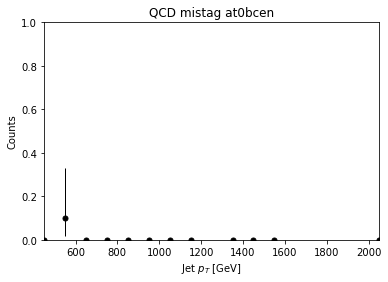

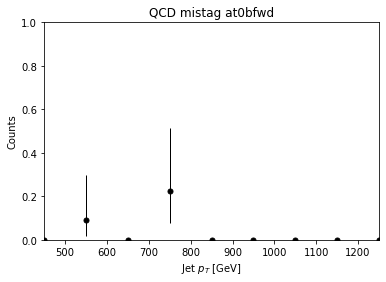

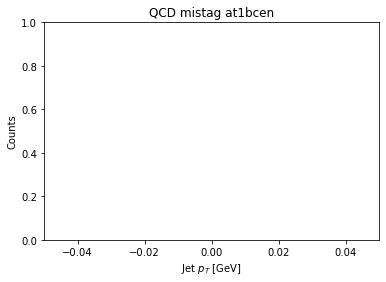

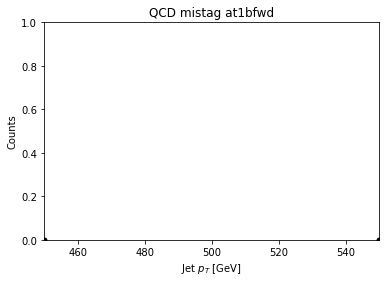

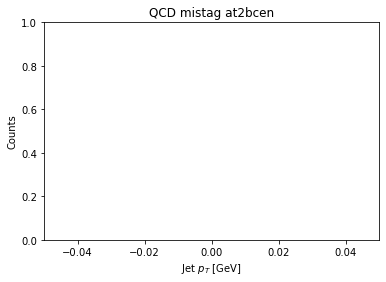

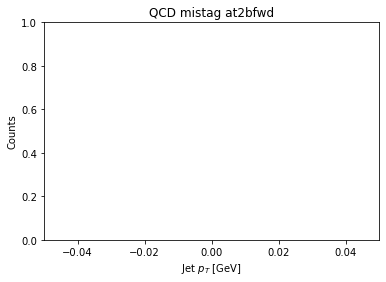

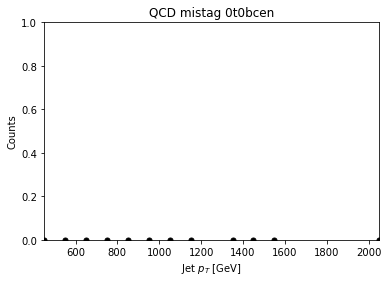

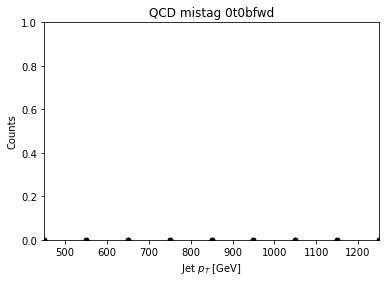

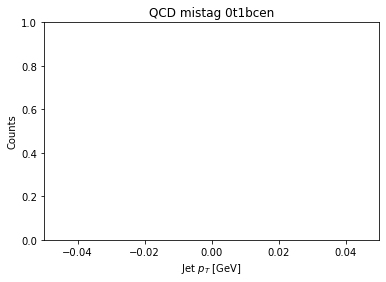

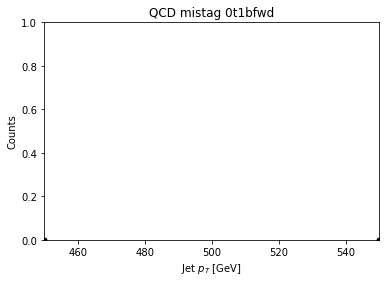

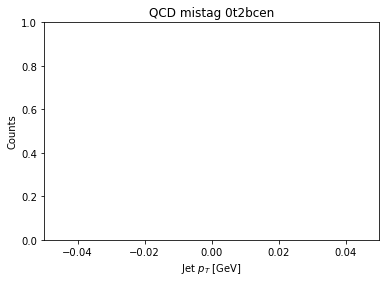

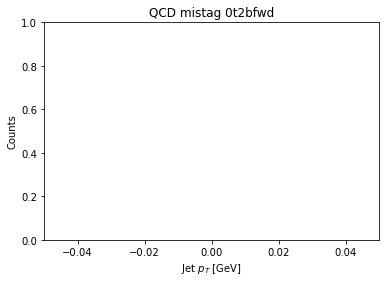

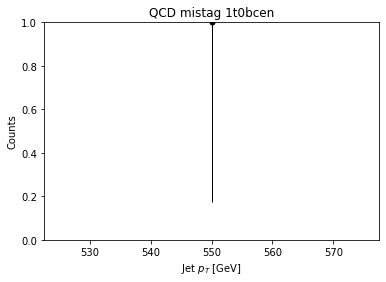

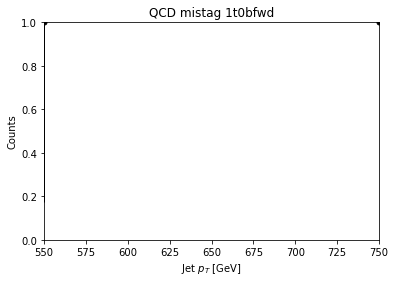

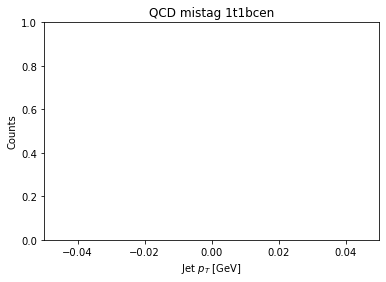

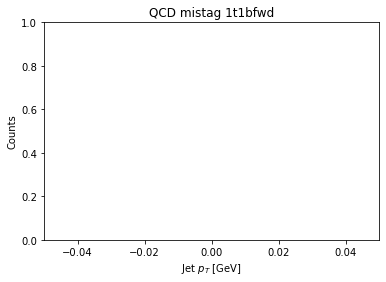

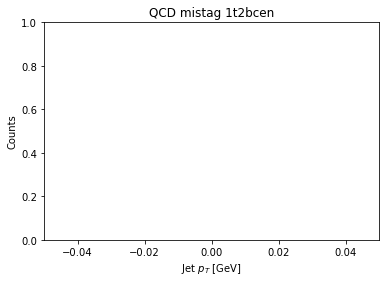

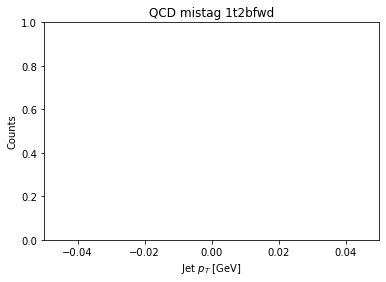

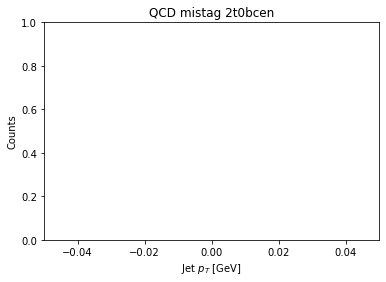

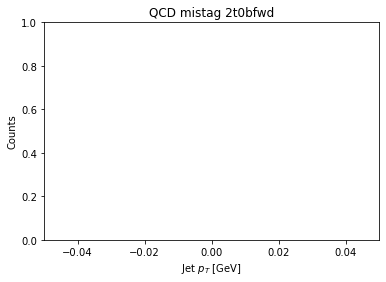

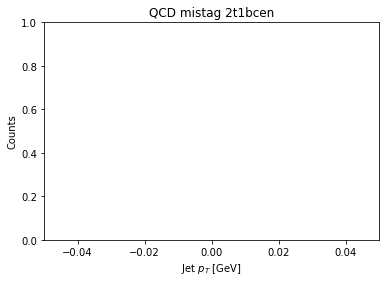

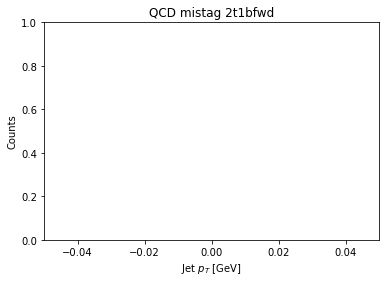

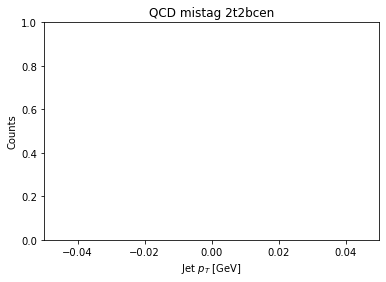

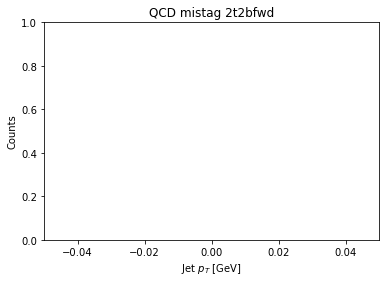

In [18]:
""" ---------------- CREATES MISTAG PLOTS ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #

SaveDirectory = maindirectory + '/MistagPlots/'
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times

print(SaveDirectory)
for iset in filesets:
    for icat in list_of_cats:
        print(iset)
        print(icat)
        title = iset + ' mistag ' + icat
        filename = 'mistag_' + iset + '_' + icat + '.' + 'png'
        print(outputs_unweighted[iset]['numerator'])
        Numerator = outputs_unweighted[iset]['numerator'].integrate('anacat', icat).integrate('dataset', iset)
        Denominator = outputs_unweighted[iset]['denominator'].integrate('anacat', icat).integrate('dataset', iset)
        print(Numerator)
        print(Denominator)
        mistag = hist.plotratio(num = Numerator, denom = Denominator,
                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                                unc = 'num')
        plt.title(title)
        plt.ylim(bottom = 0, top = 1.0)
        #plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        #print(filename + ' saved')


In [19]:
""" ---------------- LOOK UP TABLE ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #


runLUTS = True 

luts = {}

if runLUTS : 

    SaveDirectory = maindirectory + '/LookupTables/'
    DoesDirectoryExist(SaveDirectory)



    for iset in filesets:
        print('\t\tfileset: ' + iset + '\n*****************************************************\n')
        for icat in list_of_cats:
            title = iset + ' mistag ' + icat
            filename = 'mistag_' + iset + '_' + icat + '.' + 'csv'

            Numerator = outputs_unweighted[iset]['numerator'].integrate('anacat',icat).integrate('dataset',iset)
            Denominator = outputs_unweighted[iset]['denominator'].integrate('anacat',icat).integrate('dataset',iset)
            
            
            
            N_vals = Numerator.values()[()]
            D_vals = Denominator.values()[()]
            
            mistag_vals = np.where(D_vals > 0, N_vals / D_vals, 0)

            p_vals = [] # Momentum values
            for iden in Numerator.identifiers('jetpt'):
                p_vals.append(iden)
                
                

            print('fileset:  ' + iset)
            print('category: ' + icat)
            print('________________________________________________\n')
            print("N values = \n", N_vals)
            print("D values = \n", D_vals)
            print()
            
            d = {'pT': p_vals, 'M(pT)': mistag_vals}
            
            print("d vals = ", d)
            print()
            df = pd.DataFrame(data=d)
            luts[icat] = df

            with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
                print(df)
            print('\n')

            df.to_csv(SaveDirectory+filename) # use later to collect bins and weights for re-scaling
else : 
    iset = 'QCD'
    print('\t\tfileset: ' + iset + '\n*****************************************************\n')
    for icat in list_of_cats:
        title = iset + ' mistag ' + icat
        filename = 'mistag_' + iset + '_' + icat + '.' + 'csv'
        luts[icat] = pd.read_csv(filename)

		fileset: QCD
*****************************************************

fileset:  QCD
category: at0bcen
________________________________________________

N values = 
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
D values = 
 [ 0.  0.  0.  0.  2. 10.  9.  5.  2.  3.  2.  1.  0.  2.  2.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

d vals =  {'pT': [<Interval ([0, 100)) instance at 0x7fb8082cfd50>, <Interval ([100, 200)) instance at 0x7fb7e34f0590>, <Interval ([200, 300)) instance at 0x7fb7e34f07d0>, <Interval ([300, 400)) instance at 0x7fb7e34f0810>, <Interval ([400, 500)) instance at 0x7fb7e34f0910>, <Interval ([500, 600)) instance at 0x7fb7e34f0950>, <Interval ([600, 700)) instance at 0x7fb7e34f0990>, <Interval ([700, 800)) instance at 0x7fb7e34f09d0>, <Interval ([800, 900)) instance



fileset:  QCD
category: 1t1bcen
________________________________________________

N values = 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
D values = 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

d vals =  {'pT': [<Interval ([0, 100)) instance at 0x7fb8082cfd50>, <Interval ([100, 200)) instance at 0x7fb7e34f0590>, <Interval ([200, 300)) instance at 0x7fb7e34f07d0>, <Interval ([300, 400)) instance at 0x7fb7e34f0810>, <Interval ([400, 500)) instance at 0x7fb7e34f0910>, <Interval ([500, 600)) instance at 0x7fb7e34f0950>, <Interval ([600, 700)) instance at 0x7fb7e34f0990>, <Interval ([700, 800)) instance at 0x7fb7e34f09d0>, <Interval ([800, 900)) instance at 0x7fb7e34f08d0>, <Interval ([900, 1000)) instance at 0x7fb7e34f0a10>, <Interval ([1000, 1100)) instance at 0x7fb7e

In [20]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 8849.37974031424


In [21]:
tstart = time.time()

fileset = {
    'QCD':qcdfiles
}

outputs_weighted = {}

output_weighted = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=TTbarResProcessor(UseLookUpTables=True, lu=luts),
                                  #executor=processor.dask_executor,
                                  #executor=processor.iterative_executor,
                                  executor=processor.futures_executor,
                                  executor_args={
                                      'client': client, 
                                      'nano':False, 
                                      'flatten':True, 
                                      'skipbadfiles':False,
                                      'workers': 2},
                                  chunksize=10000, maxchunks=10
                                 )

elapsed = time.time() - tstart
outputs_weighted['QCD'] = output_weighted
print(output_weighted)
print(elapsed)
#util.save(output_weighted, 'TTbarResCoffea_full_weighted_QCD_output_100000chunksize_100chunks.coffea')

['At0bcen', 'At0bfwd', 'At1bcen', 'At1bfwd', 'At2bcen', 'At2bfwd', 'at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']


bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800)) instance at 0x7fb7e3465310>
 <Interval ([1800, 1900)) instance

135               499.75    [400, 500)         4      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800)) in

135               499.75    [400, 500)         4  0.000000 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800)) i

135               499.75    [400, 500)         4      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800)) in

135               499.75    [400, 500)         4      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800)) in

135               499.75    [400, 500)         4      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800)) in

135               499.75    [400, 500)         4      0.0 bin_widths = 
 
[<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700)) instance at 0x7fb7e34651d0>
 <Interval ([1700, 1800)) ins

              dtype='interval[int64]')IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')


 Bin Number = 
 
 Bin Number = 
[4, 6, 7, 4, 6, ..., 6, 13, 15, 6, 4]
Length: 136
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49] 
[4, 8, 9, 5, 10, ..., 8, 8, 6, 4, 5]
Length: 131
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]


0bcen
*************************************************

0bcen
*************************************************

     transverse momentum      BinWidth BinNumber  Weights
0                 499.50    [400, 500)         4      0.0
1                 605.00    [600, 700)         6      0.0
2                 790.50    [700, 800)         7      0.0
3                 474.00    [400, 500)         4      0.0
4                 649.00    [600, 700)         6      0.0
5                 487.00 

135               499.75    [400, 500)         4      0.0 

     transverse momentum      BinWidth BinNumber  Weights
0                 419.50    [400, 500)         4      0.0
1                 891.00    [800, 900)         8      0.0
2                 991.00   [900, 1000)         9      0.0
3                 543.00    [500, 600)         5      0.1
4                1004.00  [1000, 1100)        10      0.0
5                 520.00    [500, 600)         5      0.1
6                 600.50    [600, 700)         6      0.0
7                 606.50    [600, 700)         6      0.0
8                 518.00    [500, 600)         5      0.1
9                 558.50    [500, 600)         5      0.1
10               1098.00  [1000, 1100)        10      0.0
11                465.50    [400, 500)         4      0.0
12                786.00    [700, 800)         7      0.0
13                610.50    [600, 700)         6      0.0
14               1268.00  [1200, 1300)        12      0.0
15          

 <Interval ([4900, 5000)) instance at 0x7fb7e3465a10>][<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800)) instance at 0x7fb7e3465

135               499.75    [400, 500)         4  0.000000 
     transverse momentum      BinWidth BinNumber   Weights
0                 419.50    [400, 500)         4  0.000000
1                 891.00    [800, 900)         8  0.000000
2                 991.00   [900, 1000)         9  0.000000
3                 543.00    [500, 600)         5  0.090909
4                1004.00  [1000, 1100)        10  0.000000
5                 520.00    [500, 600)         5  0.090909
6                 600.50    [600, 700)         6  0.000000
7                 606.50    [600, 700)         6  0.000000
8                 518.00    [500, 600)         5  0.090909
9                 558.50    [500, 600)         5  0.090909
10               1098.00  [1000, 1100)        10  0.000000
11                465.50    [400, 500)         4  0.000000
12                786.00    [700, 800)         7  0.222222
13                610.50    [600, 700)         6  0.000000
14               1268.00  [1200, 1300)        12  0.000

 <Interval ([4900, 5000)) instance at 0x7fb7e3465a10>]

 pT = 
 [ 419.5   891.    991.    543.   1004.    520.    600.5   606.5   518.
  558.5  1098.    465.5   786.    610.5  1268.    553.5   751.    581.
  439.75  815.5   401.75 1452.   1250.    402.    848.5   700.5   585.5
 1388.   1207.    697.5   673.5   952.    555.5   607.5   822.5  1106.
  526.5  1276.    874.5   769.    750.    561.5   767.   1100.    762.
 1505.   1009.5   453.   1215.   1774.   1069.    468.   1147.    709.
  526.   2017.   1286.   1061.   1227.    964.5   492.    515.    552.
 1217.    970.   1579.   1250.   1099.   1027.    709.5   506.75 1155.
  655.    414.75  887.    853.5   826.    995.    776.5   466.5   400.75
  456.    880.5   438.75  850.5   456.5   414.75  568.5   580.    837.5
  690.5   613.    832.    529.5   976.    885.5   823.5  1020.5   405.
  473.   1261.    656.    763.    728.5  1098.    466.25  524.    692.
  734.    564.5   585.5   498.   1405.    900.5   558.    633.    584.5
  790.  

130               595.50    [500, 600)         5      0.0 
     transverse momentum      BinWidth BinNumber  Weights
0                 499.50    [400, 500)         4      0.0
1                 605.00    [600, 700)         6      0.0
2                 790.50    [700, 800)         7      0.0
3                 474.00    [400, 500)         4      0.0
4                 649.00    [600, 700)         6      0.0
5                 487.00    [400, 500)         4      0.0
6                 712.00    [700, 800)         7      0.0
7                 997.50   [900, 1000)         9      0.0
8                1085.00  [1000, 1100)        10      0.0
9                 447.00    [400, 500)         4      0.0
10                501.25    [500, 600)         5      0.0
11                776.00    [700, 800)         7      0.0
12                647.00    [600, 700)         6      0.0
13               1052.00  [1000, 1100)        10      0.0
14                892.50    [800, 900)         8      0.0
15           

 <Interval ([4900, 5000)) instance at 0x7fb7e3465a10>]bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800)) instance

130               595.50    [500, 600)         5      0.0      transverse momentum      BinWidth BinNumber  Weights
0                 499.50    [400, 500)         4      0.0
1                 605.00    [600, 700)         6      0.0
2                 790.50    [700, 800)         7      0.0
3                 474.00    [400, 500)         4      0.0
4                 649.00    [600, 700)         6      0.0
5                 487.00    [400, 500)         4      0.0
6                 712.00    [700, 800)         7      0.0
7                 997.50   [900, 1000)         9      0.0
8                1085.00  [1000, 1100)        10      0.0
9                 447.00    [400, 500)         4      0.0
10                501.25    [500, 600)         5      0.0
11                776.00    [700, 800)         7      0.0
12                647.00    [600, 700)         6      0.0
13               1052.00  [1000, 1100)        10      0.0
14                892.50    [800, 900)         8      0.0
15            

 <Interval ([4900, 5000)) instance at 0x7fb7e3465a10>]
[<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800)) instance at 0x7fb7e346

135               499.75    [400, 500)         4      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800)) in

130               595.50    [500, 600)         5      0.0 


 Bin Number = 
 bin_widths = 
 [4, 6, 7, 4, 6, ..., 6, 13, 15, 6, 4]
Length: 136
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49][<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interv

135               499.75    [400, 500)         4      0.0[4, 8, 9, 5, 10, ..., 8, 8, 6, 4, 5]
Length: 131
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49] 



2bfwd
*************************************************
bin_widths = 

 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 15

130               595.50    [500, 600)         5      0.0  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]



 bin_widths -> Readable Bins = 
 bin_widths = 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]') 
[<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <

135               499.75    [400, 500)         4      0.0  IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')


bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) in

130               595.50    [500, 600)         5      0.1  

bin_widths = 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]') [<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) ins

135               499.75    [400, 500)         4  0.000000 

 Bin Number = 

 bin_widths = 
[4, 8, 9, 5, 10, ..., 8, 8, 6, 4, 5]
Length: 131
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]
 
0bfwd
*************************************************
[<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <In

130               595.50    [500, 600)         5  0.090909 
 bin_widths -> Readable Bins = 

 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')bin_widths = 
 
[<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e346

135               499.75    [400, 500)         4      0.0 

bin_widths = 

 Bin Number = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval (

130               595.50    [500, 600)         5      0.0
 
 bin_widths -> Readable Bins = 

 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')
bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e346

135               499.75    [400, 500)         4      0.0 
 bin_widths -> Readable Bins = 


bin_widths = 
  IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')[<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651

130               595.50    [500, 600)         5      0.0 

bin_widths = 
 
 Bin Number = 
[<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700)) instance at 0x7fb7e34651d0>
 <Interval (

135               499.75    [400, 500)         4      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800)) in

130               595.50    [500, 600)         5      0.0 


 Bin Number = 
bin_widths = 
  [<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700)) instance at 0x7fb7e34651d0>
 <Interval 

135               499.75    [400, 500)         4      0.0 


 Bin Number = 
bin_widths = 
  [4, 8, 9, 5, 10, ..., 8, 8, 6, 4, 5]
Length: 131
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49][<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interva

130               595.50    [500, 600)         5      0.0 

 Bin Number = 
 
[4, 6, 7, 4, 6, ..., 6, 13, 15, 6, 4]
Length: 136
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]bin_widths = 
 
[<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Inter

135               499.75    [400, 500)         4      0.0 


bin_widths = 

 bin_widths -> Readable Bins = 
  [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34

130               595.50    [500, 600)         5      0.10bfwd
*************************************************
 


bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700))

135               499.75    [400, 500)         4  0.000000 


 BinKeys = 

 bin_widths = 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1

130               595.50    [500, 600)         5  0.090909     transverse momentum      BinWidth BinNumber  Weights
0                 499.50    [400, 500)         4      0.0
1                 605.00    [600, 700)         6      0.0
2                 790.50    [700, 800)         7      0.0
3                 474.00    [400, 500)         4      0.0
4                 649.00    [600, 700)         6      0.0
5                 487.00    [400, 500)         4      0.0
6                 712.00    [700, 800)         7      0.0
7                 997.50   [900, 1000)         9      0.0
8                1085.00  [1000, 1100)        10      0.0
9                 447.00    [400, 500)         4      0.0
10                501.25    [500, 600)         5      0.0
11                776.00    [700, 800)         7      0.0
12                647.00    [600, 700)         6      0.0
13               1052.00  [1000, 1100)        10      0.0
14                892.50    [800, 900)         8      0.0
15            

 <Interval ([4900, 5000)) instance at 0x7fb7e3465b10>]
[<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700)) instance at 0x7fb7e34651d0>
 <Interval ([1700, 1800)) instance at 0x7fb7e346

130               595.50    [500, 600)         5      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700)) instance at 0x7fb7e34651d0>
 <Interval ([1700, 1800)) in

135               499.75    [400, 500)         4      0.0
 
 pT = 

 
bin_widths = 
[ 419.5   891.    991.    543.   1004.    520.    600.5   606.5   518.
  558.5  1098.    465.5   786.    610.5  1268.    553.5   751.    581.
  439.75  815.5   401.75 1452.   1250.    402.    848.5   700.5   585.5
 1388.   1207.    697.5   673.5   952.    555.5   607.5   822.5  1106.
  526.5  1276.    874.5   769.    750.    561.5   767.   1100.    762.
 1505.   1009.5   453.   1215.   1774.   1069.    468.   1147.    709.
  526.   2017.   1286.   1061.   1227.    964.5   492.    515.    552.
 1217.    970.   1579.   1250.   1099.   1027.    709.5   506.75 1155.
  655.    414.75  887.    853.5   826.    995.    776.5   466.5   400.75
  456.    880.5   438.75  850.5   456.5   414.75  568.5   580.    837.5
  690.5   613.    832.    529.5   976.    885.5   823.5  1020.5   405.
  473.   1261.    656.    763.    728.5  1098.    466.25  524.    692.
  734.    564.5   585.5   498.   1405.    900.5   558.    63

130               595.50    [500, 600)         5      0.0      transverse momentum      BinWidth BinNumber  Weights
0                 499.50    [400, 500)         4      0.0
1                 605.00    [600, 700)         6      0.0
2                 790.50    [700, 800)         7      0.0
3                 474.00    [400, 500)         4      0.0
4                 649.00    [600, 700)         6      0.0
5                 487.00    [400, 500)         4      0.0
6                 712.00    [700, 800)         7      0.0
7                 997.50   [900, 1000)         9      0.0
8                1085.00  [1000, 1100)        10      0.0
9                 447.00    [400, 500)         4      0.0
10                501.25    [500, 600)         5      0.0
11                776.00    [700, 800)         7      0.0
12                647.00    [600, 700)         6      0.0
13               1052.00  [1000, 1100)        10      0.0
14                892.50    [800, 900)         8      0.0
15            

 <Interval ([4900, 5000)) instance at 0x7fb7e3465a10>][<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800)) instance at 0x7fb7e3465

130               595.50    [500, 600)         5      0.0     transverse momentum      BinWidth BinNumber  Weights
0                 499.50    [400, 500)         4      0.0
1                 605.00    [600, 700)         6      0.0
2                 790.50    [700, 800)         7      0.0
3                 474.00    [400, 500)         4      0.0
4                 649.00    [600, 700)         6      0.0
5                 487.00    [400, 500)         4      0.0
6                 712.00    [700, 800)         7      0.0
7                 997.50   [900, 1000)         9      0.0
8                1085.00  [1000, 1100)        10      0.0
9                 447.00    [400, 500)         4      0.0
10                501.25    [500, 600)         5      0.0
11                776.00    [700, 800)         7      0.0
12                647.00    [600, 700)         6      0.0
13               1052.00  [1000, 1100)        10      0.0
14                892.50    [800, 900)         8      0.0
15             

 <Interval ([4900, 5000)) instance at 0x7fb7e3465b10>][<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700)) instance at 0x7fb7e34651d0>
 <Interval ([1700, 1800)) instance at 0x7fb7e3465

130               595.50    [500, 600)         5      0.0
 
bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700)) instance at 0x7fb7e34651d0>
 <Interval ([1700, 1800)) in

135               499.75    [400, 500)         4      0.0
 pT = 
  [ 419.5   891.    991.    543.   1004.    520.    600.5   606.5   518.
  558.5  1098.    465.5   786.    610.5  1268.    553.5   751.    581.
  439.75  815.5   401.75 1452.   1250.    402.    848.5   700.5   585.5
 1388.   1207.    697.5   673.5   952.    555.5   607.5   822.5  1106.
  526.5  1276.    874.5   769.    750.    561.5   767.   1100.    762.
 1505.   1009.5   453.   1215.   1774.   1069.    468.   1147.    709.
  526.   2017.   1286.   1061.   1227.    964.5   492.    515.    552.
 1217.    970.   1579.   1250.   1099.   1027.    709.5   506.75 1155.
  655.    414.75  887.    853.5   826.    995.    776.5   466.5   400.75
  456.    880.5   438.75  850.5   456.5   414.75  568.5   580.    837.5
  690.5   613.    832.    529.5   976.    885.5   823.5  1020.5   405.
  473.   1261.    656.    763.    728.5  1098.    466.25  524.    692.
  734.    564.5   585.5   498.   1405.    900.5   558.    633.    584.5
  790

130               595.50    [500, 600)         5      0.1 

bin_widths = 
      transverse momentum      BinWidth BinNumber   Weights
0                 499.50    [400, 500)         4  0.000000
1                 605.00    [600, 700)         6  0.000000
2                 790.50    [700, 800)         7  0.222222
3                 474.00    [400, 500)         4  0.000000
4                 649.00    [600, 700)         6  0.000000
5                 487.00    [400, 500)         4  0.000000
6                 712.00    [700, 800)         7  0.222222
7                 997.50   [900, 1000)         9  0.000000
8                1085.00  [1000, 1100)        10  0.000000
9                 447.00    [400, 500)         4  0.000000
10                501.25    [500, 600)         5  0.090909
11                776.00    [700, 800)         7  0.222222
12                647.00    [600, 700)         6  0.000000
13               1052.00  [1000, 1100)        10  0.000000
14                892.50    [800, 900)  

 <Interval ([4900, 5000)) instance at 0x7fb7e3465a10>]bin_widths = 
 

 pT = 
[<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800))

130               595.50    [500, 600)         5  0.090909 

     transverse momentum      BinWidth BinNumber  Weights
0                 499.50    [400, 500)         4      0.0
1                 605.00    [600, 700)         6      0.0
2                 790.50    [700, 800)         7      0.0
3                 474.00    [400, 500)         4      0.0
4                 649.00    [600, 700)         6      0.0
5                 487.00    [400, 500)         4      0.0
6                 712.00    [700, 800)         7      0.0
7                 997.50   [900, 1000)         9      0.0
8                1085.00  [1000, 1100)        10      0.0
9                 447.00    [400, 500)         4      0.0
10                501.25    [500, 600)         5      0.0
11                776.00    [700, 800)         7      0.0
12                647.00    [600, 700)         6      0.0
13               1052.00  [1000, 1100)        10      0.0
14                892.50    [800, 900)         8      0.0
15         

 <Interval ([4900, 5000)) instance at 0x7fb7e3465a10>]

bin_widths = 

 pT = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)) instance at 0x7fb7e34652d0>
 <Interval ([1700, 1800)

135               499.75    [400, 500)         4      0.0 


1bcen
*************************************************


bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700

130               595.50    [500, 600)         5      0.0
 BinKeys = 
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


 bin_widths -> Readable Bins = 
 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')bin_widths = 
 

[<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7f

135               499.75    [400, 500)         4      0.0 



bin_widths = 
 1bfwd
*************************************************
[<Interval ([0, 100)) instance at 0x7fb7e345cdd0>
 <Interval ([100, 200)) instance at 0x7fb7e345ced0>
 <Interval ([200, 300)) instance at 0x7fb7e345cf10>
 <Interval ([300, 400)) instance at 0x7fb7e345cf50>
 <Interval ([400, 500)) instance at 0x7fb7e345cf90>
 <Interval ([500, 600)) instance at 0x7fb7e345cfd0>
 <Interval ([600, 700)) instance at 0x7fb7e3465050>
 <Interval ([700, 800)) instance at 0x7fb7e3465090>
 <Interval ([800, 900)) instance at 0x7fb7e34650d0>
 <Interval ([900, 1000)) instance at 0x7fb7e3465110>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465150>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465190>
 <Interval ([1200, 1300)) instance at 0x7fb7e34651d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465210>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465250>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465290>
 <Interval ([1600, 1700)

130               595.50    [500, 600)         5      0.0[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
 
 bin_widths -> Readable Bins = 
 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')
bin_widths = 
 
[<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <I

135               499.75    [400, 500)         4      0.0      transverse momentum      BinWidth BinNumber  Weights
0                 419.50    [400, 500)         4      0.0
1                 891.00    [800, 900)         8      0.0
2                 991.00   [900, 1000)         9      0.0
3                 543.00    [500, 600)         5      0.0
4                1004.00  [1000, 1100)        10      0.0
5                 520.00    [500, 600)         5      0.0
6                 600.50    [600, 700)         6      0.0
7                 606.50    [600, 700)         6      0.0
8                 518.00    [500, 600)         5      0.0
9                 558.50    [500, 600)         5      0.0
10               1098.00  [1000, 1100)        10      0.0
11                465.50    [400, 500)         4      0.0
12                786.00    [700, 800)         7      0.0
13                610.50    [600, 700)         6      0.0
14               1268.00  [1200, 1300)        12      0.0
15            

 <Interval ([4900, 5000)) instance at 0x7fb7e3465a10>]

 pT = 
 [ 419.5   891.    991.    543.   1004.    520.    600.5   606.5   518.
  558.5  1098.    465.5   786.    610.5  1268.    553.5   751.    581.
  439.75  815.5   401.75 1452.   1250.    402.    848.5   700.5   585.5
 1388.   1207.    697.5   673.5   952.    555.5   607.5   822.5  1106.
  526.5  1276.    874.5   769.    750.    561.5   767.   1100.    762.
 1505.   1009.5   453.   1215.   1774.   1069.    468.   1147.    709.
  526.   2017.   1286.   1061.   1227.    964.5   492.    515.    552.
 1217.    970.   1579.   1250.   1099.   1027.    709.5   506.75 1155.
  655.    414.75  887.    853.5   826.    995.    776.5   466.5   400.75
  456.    880.5   438.75  850.5   456.5   414.75  568.5   580.    837.5
  690.5   613.    832.    529.5   976.    885.5   823.5  1020.5   405.
  473.   1261.    656.    763.    728.5  1098.    466.25  524.    692.
  734.    564.5   585.5   498.   1405.    900.5   558.    633.    584.5
  790.  

130               595.50    [500, 600)         5      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700)) instance at 0x7fb7e34651d0>
 <Interval ([1700, 1800)) in

130               595.50    [500, 600)         5      0.1 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700)) instance at 0x7fb7e34651d0>
 <Interval ([1700, 1800)) in

130               595.50    [500, 600)         5  0.090909 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700)) instance at 0x7fb7e34651d0>
 <Interval ([1700, 1800)) i

130               595.50    [500, 600)         5      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700)) instance at 0x7fb7e34651d0>
 <Interval ([1700, 1800)) in

130               595.50    [500, 600)         5      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700)) instance at 0x7fb7e34651d0>
 <Interval ([1700, 1800)) in

130               595.50    [500, 600)         5      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345ccd0>
 <Interval ([100, 200)) instance at 0x7fb7e345cdd0>
 <Interval ([200, 300)) instance at 0x7fb7e345ce10>
 <Interval ([300, 400)) instance at 0x7fb7e345ce50>
 <Interval ([400, 500)) instance at 0x7fb7e345ce90>
 <Interval ([500, 600)) instance at 0x7fb7e345ced0>
 <Interval ([600, 700)) instance at 0x7fb7e345cf10>
 <Interval ([700, 800)) instance at 0x7fb7e345cf50>
 <Interval ([800, 900)) instance at 0x7fb7e345cf90>
 <Interval ([900, 1000)) instance at 0x7fb7e345cfd0>
 <Interval ([1000, 1100)) instance at 0x7fb7e3465050>
 <Interval ([1100, 1200)) instance at 0x7fb7e3465090>
 <Interval ([1200, 1300)) instance at 0x7fb7e34650d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e3465110>
 <Interval ([1400, 1500)) instance at 0x7fb7e3465150>
 <Interval ([1500, 1600)) instance at 0x7fb7e3465190>
 <Interval ([1600, 1700)) instance at 0x7fb7e34651d0>
 <Interval ([1700, 1800)) in

130               595.50    [500, 600)         5      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) in

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6  0.000000 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) in

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6  0.000000 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) in

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6  0.000000 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) in

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6  0.000000 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) in

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) ins

85               686.50    [600, 700)         6      0.0 

bin_widths = 
 bin_widths = 
[<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([17

85               686.50    [600, 700)         6      0.0 

    transverse momentum      BinWidth BinNumber  Weights
0                519.00    [500, 600)         5      0.1
1               1070.00  [1000, 1100)        10      0.0
2                620.50    [600, 700)         6      0.0
3                660.00    [600, 700)         6      0.0
4               1133.00  [1100, 1200)        11      0.0
5                448.25    [400, 500)         4      0.0
6               1214.00  [1200, 1300)        12      0.0
7                745.00    [700, 800)         7      0.0
8               1183.00  [1100, 1200)        11      0.0
9                746.00    [700, 800)         7      0.0
10               423.00    [400, 500)         4      0.0
11               797.00    [700, 800)         7      0.0
12               911.00   [900, 1000)         9      0.0
13               696.00    [600, 700)         6      0.0
14               418.25    [400, 500)         4      0.0
15               565.50    [5

 1289.    492.5   612.    714.    686.5 ] 
[<Interval ([0, 100)) instance at 0x7fb7e346eed0>
 <Interval ([100, 200)) instance at 0x7fb7e346e310>
 <Interval ([200, 300)) instance at 0x7fb7e346e2d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e190>
 <Interval ([400, 500)) instance at 0x7fb7e346e110>
 <Interval ([500, 600)) instance at 0x7fb7e346e0d0>
 <Interval ([600, 700)) instance at 0x7fb7e346e090>
 <Interval ([700, 800)) instance at 0x7fb7e346e290>
 <Interval ([800, 900)) instance at 0x7fb7e346e250>
 <Interval ([900, 1000)) instance at 0x7fb7e346ea90>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e950>
 <Interval ([1100, 1200)) instance at 0x7fb7e346ead0>
 <Interval ([1200, 1300)) instance at 0x7fb7e346ea50>
 <Interval ([1300, 1400)) instance at 0x7fb7e346ef90>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e910>
 <Interval ([1500, 1600)) instance at 0x7fb7e346ef50>
 <Interval ([1600, 1700)) instance at 0x7fb7e346ecd0>
 <Interval ([1700, 1800)) instance at 0x7fb7e346e750>
 <Inte

85               686.50    [600, 700)         6      0.00bfwd
*************************************************
 

bin_widths = 

 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) 

90               421.50    [400, 500)         4  0.000000
 

 bin_widths -> Readable Bins = 

 bin_widths = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')
[<Interval ([0, 100)) instance at 0x7fb7e346eed0>
 <Interval ([100, 200)) instance at 0x7fb7e346e310>
 <Interval ([200, 300)) instance at 0x7fb7e346e2d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e190>
 <Interval ([400, 500)) instance at 0x7fb7e346e110>
 <Interval ([500, 600)) instance at 0x7fb7e346e0d0>
 <Interval ([600, 700)) instance at 0x7fb7e346e090>
 <Interval ([700, 800)) instance at 0x7fb7e346e290>
 <Interval ([800, 900)) instance at 0x7fb7e346e250>
 <Interval ([900, 1000)) instance at 0x7fb7e346ea90>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e950>
 <Interval ([1100, 1200)) instance at 0x7fb7e346ead0>
 <Interval ([1200, 1300)) instance at 0x7fb7e346

85               686.50    [600, 700)         6      0.0 


bin_widths = 
 
 Bin Number = 
[<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval (

90               421.50    [400, 500)         4      0.0
 bin_widths -> Readable Bins = 
  

bin_widths = 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]') 
[<Interval ([0, 100)) instance at 0x7fb7e346eed0>
 <Interval ([100, 200)) instance at 0x7fb7e346e310>
 <Interval ([200, 300)) instance at 0x7fb7e346e2d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e190>
 <Interval ([400, 500)) instance at 0x7fb7e346e110>
 <Interval ([500, 600)) instance at 0x7fb7e346e0d0>
 <Interval ([600, 700)) instance at 0x7fb7e346e090>
 <Interval ([700, 800)) instance at 0x7fb7e346e290>
 <Interval ([800, 900)) instance at 0x7fb7e346e250>
 <Interval ([900, 1000)) instance at 0x7fb7e346ea90>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e950>
 <Interval ([1100, 1200)) instance at 0x7fb7e346ead0>
 <Interval ([1200, 1300)) instance at 0x7fb7e346ea

85               686.50    [600, 700)         6  0.000000[5, 10, 6, 6, 11, ..., 4, 6, 7, 8, 4]
Length: 91
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49] 



1bfwd
*************************************************

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 15

 1289.    492.5   612.    714.    686.5 ]

 BinKeys = 


 bin_widths = 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')
 [<Interval ([0, 100)) instance at 0x7fb7e346eed0>
 <Interval ([100, 200)) instance at 0x7fb7e346e310>
 <Interval ([200, 300)) instance at 0x7fb7e346e2d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e190>
 <Interval ([400, 500)) instance at 0x7fb7e346e110>
 <Interval ([500, 600)) instance at 0x7fb7e346e0d0>
 <Interval ([600, 700)) instance at 0x7fb7e346e090>
 <Interval ([700, 800)) instance at 0x7fb7e346e290>
 <Interval ([800, 900)) instance at 0x7fb7e346e250>
 <Interval ([900, 1000)) instance at 0x7fb7e346ea90>
 <Int

85               686.50    [600, 700)         6      0.0
 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e346e490>
 <Interval ([1500, 1600)) instance at 0x7fb7e346e450>
 <Interval ([1600, 1700)) instance at 0x7fb7e346e310>
 <Interval ([1700, 1800)) in

90               421.50    [400, 500)         4      0.0
 Bin Number = 
 
 
[5, 24, 13, 5, 4, ..., 12, 4, 6, 7, 6]
Length: 86
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]
bin_widths = 
 
1bfwd
*************************************************

[<Interval ([0, 100)) instance at 0x7fb7e346eed0>
 <Interval ([100, 200)) instance at 0x7fb7e346e310>
 <Interval ([200, 300)) instance at 0x7fb7e346e2d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e190>
 <Interval ([400, 500)) instance at 0x7fb7e346e110>
 <Interval ([500, 600)) instance at 0x7fb7e346e0d0>
 <Interval ([600, 700)) instance at 0x7fb7e346e090>
 <Interval ([700, 800)) instance at 0x7fb7e346e290>
 <Interval ([800, 900)) instance at 0x7fb7e346e250>
 <Interval ([900, 1000)) instance at 0x7fb7e346ea90>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e950>
 <Interval ([1100, 1200)) instance at 0x7fb7e346ead0>
 <Interval ([1200, 1300)) instance at 0x7fb7e346ea50>
 <Interval ([1300, 1400)) instance at 0x7fb7e346ef90>
 <In

85               686.50    [600, 700)         6      0.0
 
 BinKeys = 

 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]bin_widths = 
 
[<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e150>
 <Interval ([1100, 1200)) instance at 0x7fb7e346e250>
 <Interval ([1200, 1300)) instance at 0x7fb7e346e2d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e346e4d0>
 <Interval ([1400, 150

90               421.50    [400, 500)         4      0.0
 Bin Number = 
  
[5, 24, 13, 5, 4, ..., 12, 4, 6, 7, 6]
Length: 86
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]


bin_widths = 
2bcen
*************************************************
 
[<Interval ([0, 100)) instance at 0x7fb7e346eed0>
 <Interval ([100, 200)) instance at 0x7fb7e346e310>
 <Interval ([200, 300)) instance at 0x7fb7e346e2d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e190>
 <Interval ([400, 500)) instance at 0x7fb7e346e110>
 <Interval ([500, 600)) instance at 0x7fb7e346e0d0>
 <Interval ([600, 700)) instance at 0x7fb7e346e090>
 <Interval ([700, 800)) instance at 0x7fb7e346e290>
 <Interval ([800, 900)) instance at 0x7fb7e346e250>
 <Interval ([900, 1000)) instance at 0x7fb7e346ea90>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e950>
 <Interval ([1100, 1200)) instance at 0x7fb7e346ead0>
 <Interval ([1200, 1300)) instance at 0x7fb7e346ea50>
 <Interval ([1300, 1400)) instance at 0x7fb7e346ef90>
 <In

85               686.50    [600, 700)         6      0.0[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
 
 bin_widths -> Readable Bins = 

 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')
bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf10>
 <Interval ([100, 200)) instance at 0x7fb7e345cc10>
 <Interval ([200, 300)) instance at 0x7fb7e345c8d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e8d0>
 <Interval ([400, 500)) instance at 0x7fb7e346eb10>
 <Interval ([500, 600)) instance at 0x7fb7e346ea90>
 <Interval ([600, 700)) instance at 0x7fb7e346e9d0>
 <Interval ([700, 800)) instance at 0x7fb7e346efd0>
 <Interval ([800, 900)) instance at 0x7fb7e346e050>
 <Interval ([900, 1000)) instance at 0x7fb7e346e0d0>
 <In

90               421.50    [400, 500)         4      0.0
 bin_widths -> Readable Bins = 
  
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e346eed0>
 <Interval ([100, 200)) instance at 0x7fb7e346e310>
 <Interval ([200, 300)) instance at 0x7fb7e346e2d0>
 <Interval ([300, 400)) instance at 0x7fb7e346e190>
 <Interval ([400, 500)) instance at 0x7fb7e346e110>
 <Interval ([500, 600)) instance at 0x7fb7e346e0d0>
 <Interval ([600, 700)) instance at 0x7fb7e346e090>
 <Interval ([700, 800)) instance at 0x7fb7e346e290>
 <Interval ([800, 900)) instance at 0x7fb7e346e250>
 <Interval ([900, 1000)) instance at 0x7fb7e346ea90>
 <Interval ([1000, 1100)) instance at 0x7fb7e346e950>
 <Interval ([1100, 1200)) instance at 0x7fb7e346ead0>
 <Interval ([1200, 1300)) instance at 0x7fb7e346ea

85               686.50    [600, 700)         6      0.0 


 Bin Number = 
 [5, 10, 6, 6, 11, ..., 4, 6, 7, 8, 4]
Length: 91
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

0bfwd
*************************************************

    transverse momentum      BinWidth BinNumber   Weights
0                519.00    [500, 600)         5  0.090909
1               1070.00  [1000, 1100)        10  0.000000
2                620.50    [600, 700)         6  0.000000
3                660.00    [600, 700)         6  0.000000
4               1133.00  [1100, 1200)        11  0.000000
5                448.25    [400, 500)         4  0.000000
6               1214.00  [1200, 1300)        12  0.000000
7                745.00    [700, 800)         7  0.222222
8               1183.00  [1100, 1200)        11  0.000000
9                746.00    [700, 800)         7  0.222222
10               423.00    [400, 500)         4  0.000000
11               797.00    [700, 800)         7  0.222222
1

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e345cc10>]

 pT = 
 [ 519.   1070.    620.5   660.   1133.    448.25 1214.    745.   1183.
  746.    423.    797.    911.    696.    418.25  565.5  1072.    753.
  873.    700.    803.5   467.75 1159.    664.    933.5   624.5   487.
  493.75  646.    447.   1079.    778.5   534.5  1036.    721.    528.5
  468.5   520.    730.5  1303.    443.75  745.    491.5   465.    910.
  422.75  504.75  874.    747.   1031.    511.5  1212.    591.    909.
  763.    688.5   546.   1262.    553.    489.5   994.   1041.    691.
  525.    846.5  1248.    487.    951.    733.    425.75  561.    639.
 1111.    579.5  1217.    403.   1805.    551.    862.5   493.25  614.
  418.75  676.    600.5   488.75 1157.    431.25  630.5   723.    863.
  421.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex

 <Interval ([4900, 5000)) instance at 0x7fb7e2433050>]

 pT = 
 [1597.    732.5   783.5   585.5  1298.   1130.    700.    511.   1759.
  564.5  1278.    614.    954.5   687.   1194.    501.    565.5   710.
 1025.    708.    806.5   598.5   976.5  1686.    630.5   601.5   662.5
  556.5  1094.    444.75  456.75 1092.   1264.    976.    518.5   496.25
  659.   1196.    678.   1182.    758.    740.    486.25 1894.    815.
  617.   1225.    513.    510.    856.    505.5  1095.   1340.   1488.
 1471.    662.5   742.   1256.    946.5   536.    950.5  1357.    599.
  685.    594.5  1392.    574.5  1820.    437.75  410.25  498.75  512.5
  723.    749.   1296.    463.5   448.75 1705.   2036.   1124.    402.5
 1812.    442.25  444.    440.75 1572.    742.    734.5   773.5   959.5
 1058.    495.75  416.5   416.5   622.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widt

 <Interval ([4900, 5000)) instance at 0x7fb7e2433050>]

 pT = 
 [1597.    732.5   783.5   585.5  1298.   1130.    700.    511.   1759.
  564.5  1278.    614.    954.5   687.   1194.    501.    565.5   710.
 1025.    708.    806.5   598.5   976.5  1686.    630.5   601.5   662.5
  556.5  1094.    444.75  456.75 1092.   1264.    976.    518.5   496.25
  659.   1196.    678.   1182.    758.    740.    486.25 1894.    815.
  617.   1225.    513.    510.    856.    505.5  1095.   1340.   1488.
 1471.    662.5   742.   1256.    946.5   536.    950.5  1357.    599.
  685.    594.5  1392.    574.5  1820.    437.75  410.25  498.75  512.5
  723.    749.   1296.    463.5   448.75 1705.   2036.   1124.    402.5
 1812.    442.25  444.    440.75 1572.    742.    734.5   773.5   959.5
 1058.    495.75  416.5   416.5   622.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widt

 <Interval ([4900, 5000)) instance at 0x7fb7e2433050>]

 pT = 
 [1597.    732.5   783.5   585.5  1298.   1130.    700.    511.   1759.
  564.5  1278.    614.    954.5   687.   1194.    501.    565.5   710.
 1025.    708.    806.5   598.5   976.5  1686.    630.5   601.5   662.5
  556.5  1094.    444.75  456.75 1092.   1264.    976.    518.5   496.25
  659.   1196.    678.   1182.    758.    740.    486.25 1894.    815.
  617.   1225.    513.    510.    856.    505.5  1095.   1340.   1488.
 1471.    662.5   742.   1256.    946.5   536.    950.5  1357.    599.
  685.    594.5  1392.    574.5  1820.    437.75  410.25  498.75  512.5
  723.    749.   1296.    463.5   448.75 1705.   2036.   1124.    402.5
 1812.    442.25  444.    440.75 1572.    742.    734.5   773.5   959.5
 1058.    495.75  416.5   416.5   622.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widt

 <Interval ([4900, 5000)) instance at 0x7fb7e2433050>]

 pT = 
 [1597.    732.5   783.5   585.5  1298.   1130.    700.    511.   1759.
  564.5  1278.    614.    954.5   687.   1194.    501.    565.5   710.
 1025.    708.    806.5   598.5   976.5  1686.    630.5   601.5   662.5
  556.5  1094.    444.75  456.75 1092.   1264.    976.    518.5   496.25
  659.   1196.    678.   1182.    758.    740.    486.25 1894.    815.
  617.   1225.    513.    510.    856.    505.5  1095.   1340.   1488.
 1471.    662.5   742.   1256.    946.5   536.    950.5  1357.    599.
  685.    594.5  1392.    574.5  1820.    437.75  410.25  498.75  512.5
  723.    749.   1296.    463.5   448.75 1705.   2036.   1124.    402.5
 1812.    442.25  444.    440.75 1572.    742.    734.5   773.5   959.5
 1058.    495.75  416.5   416.5   622.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widt

 <Interval ([4900, 5000)) instance at 0x7fb7e2433050>]

 pT = 
 [1597.    732.5   783.5   585.5  1298.   1130.    700.    511.   1759.
  564.5  1278.    614.    954.5   687.   1194.    501.    565.5   710.
 1025.    708.    806.5   598.5   976.5  1686.    630.5   601.5   662.5
  556.5  1094.    444.75  456.75 1092.   1264.    976.    518.5   496.25
  659.   1196.    678.   1182.    758.    740.    486.25 1894.    815.
  617.   1225.    513.    510.    856.    505.5  1095.   1340.   1488.
 1471.    662.5   742.   1256.    946.5   536.    950.5  1357.    599.
  685.    594.5  1392.    574.5  1820.    437.75  410.25  498.75  512.5
  723.    749.   1296.    463.5   448.75 1705.   2036.   1124.    402.5
 1812.    442.25  444.    440.75 1572.    742.    734.5   773.5   959.5
 1058.    495.75  416.5   416.5   622.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widt

 <Interval ([4900, 5000)) instance at 0x7fb7e2433050>]

 pT = 
 [1597.    732.5   783.5   585.5  1298.   1130.    700.    511.   1759.
  564.5  1278.    614.    954.5   687.   1194.    501.    565.5   710.
 1025.    708.    806.5   598.5   976.5  1686.    630.5   601.5   662.5
  556.5  1094.    444.75  456.75 1092.   1264.    976.    518.5   496.25
  659.   1196.    678.   1182.    758.    740.    486.25 1894.    815.
  617.   1225.    513.    510.    856.    505.5  1095.   1340.   1488.
 1471.    662.5   742.   1256.    946.5   536.    950.5  1357.    599.
  685.    594.5  1392.    574.5  1820.    437.75  410.25  498.75  512.5
  723.    749.   1296.    463.5   448.75 1705.   2036.   1124.    402.5
 1812.    442.25  444.    440.75 1572.    742.    734.5   773.5   959.5
 1058.    495.75  416.5   416.5   622.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widt

 <Interval ([4900, 5000)) instance at 0x7fb7e2433050>]

 pT = 
 [1597.    732.5   783.5   585.5  1298.   1130.    700.    511.   1759.
  564.5  1278.    614.    954.5   687.   1194.    501.    565.5   710.
 1025.    708.    806.5   598.5   976.5  1686.    630.5   601.5   662.5
  556.5  1094.    444.75  456.75 1092.   1264.    976.    518.5   496.25
  659.   1196.    678.   1182.    758.    740.    486.25 1894.    815.
  617.   1225.    513.    510.    856.    505.5  1095.   1340.   1488.
 1471.    662.5   742.   1256.    946.5   536.    950.5  1357.    599.
  685.    594.5  1392.    574.5  1820.    437.75  410.25  498.75  512.5
  723.    749.   1296.    463.5   448.75 1705.   2036.   1124.    402.5
 1812.    442.25  444.    440.75 1572.    742.    734.5   773.5   959.5
 1058.    495.75  416.5   416.5   622.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widt

 <Interval ([4900, 5000)) instance at 0x7fb7e2433050>]

 pT = 
 [1597.    732.5   783.5   585.5  1298.   1130.    700.    511.   1759.
  564.5  1278.    614.    954.5   687.   1194.    501.    565.5   710.
 1025.    708.    806.5   598.5   976.5  1686.    630.5   601.5   662.5
  556.5  1094.    444.75  456.75 1092.   1264.    976.    518.5   496.25
  659.   1196.    678.   1182.    758.    740.    486.25 1894.    815.
  617.   1225.    513.    510.    856.    505.5  1095.   1340.   1488.
 1471.    662.5   742.   1256.    946.5   536.    950.5  1357.    599.
  685.    594.5  1392.    574.5  1820.    437.75  410.25  498.75  512.5
  723.    749.   1296.    463.5   448.75 1705.   2036.   1124.    402.5
 1812.    442.25  444.    440.75 1572.    742.    734.5   773.5   959.5
 1058.    495.75  416.5   416.5   622.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widt

 <Interval ([4900, 5000)) instance at 0x7fb7e2433050>]

 pT = 
 [1597.    732.5   783.5   585.5  1298.   1130.    700.    511.   1759.
  564.5  1278.    614.    954.5   687.   1194.    501.    565.5   710.
 1025.    708.    806.5   598.5   976.5  1686.    630.5   601.5   662.5
  556.5  1094.    444.75  456.75 1092.   1264.    976.    518.5   496.25
  659.   1196.    678.   1182.    758.    740.    486.25 1894.    815.
  617.   1225.    513.    510.    856.    505.5  1095.   1340.   1488.
 1471.    662.5   742.   1256.    946.5   536.    950.5  1357.    599.
  685.    594.5  1392.    574.5  1820.    437.75  410.25  498.75  512.5
  723.    749.   1296.    463.5   448.75 1705.   2036.   1124.    402.5
 1812.    442.25  444.    440.75 1572.    742.    734.5   773.5   959.5
 1058.    495.75  416.5   416.5   622.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widt

 <Interval ([4900, 5000)) instance at 0x7fb7e2433050>]

 pT = 
 [1597.    732.5   783.5   585.5  1298.   1130.    700.    511.   1759.
  564.5  1278.    614.    954.5   687.   1194.    501.    565.5   710.
 1025.    708.    806.5   598.5   976.5  1686.    630.5   601.5   662.5
  556.5  1094.    444.75  456.75 1092.   1264.    976.    518.5   496.25
  659.   1196.    678.   1182.    758.    740.    486.25 1894.    815.
  617.   1225.    513.    510.    856.    505.5  1095.   1340.   1488.
 1471.    662.5   742.   1256.    946.5   536.    950.5  1357.    599.
  685.    594.5  1392.    574.5  1820.    437.75  410.25  498.75  512.5
  723.    749.   1296.    463.5   448.75 1705.   2036.   1124.    402.5
 1812.    442.25  444.    440.75 1572.    742.    734.5   773.5   959.5
 1058.    495.75  416.5   416.5   622.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widt

 <Interval ([4900, 5000)) instance at 0x7fb7e2433050>]

 pT = 
 [1597.    732.5   783.5   585.5  1298.   1130.    700.    511.   1759.
  564.5  1278.    614.    954.5   687.   1194.    501.    565.5   710.
 1025.    708.    806.5   598.5   976.5  1686.    630.5   601.5   662.5
  556.5  1094.    444.75  456.75 1092.   1264.    976.    518.5   496.25
  659.   1196.    678.   1182.    758.    740.    486.25 1894.    815.
  617.   1225.    513.    510.    856.    505.5  1095.   1340.   1488.
 1471.    662.5   742.   1256.    946.5   536.    950.5  1357.    599.
  685.    594.5  1392.    574.5  1820.    437.75  410.25  498.75  512.5
  723.    749.   1296.    463.5   448.75 1705.   2036.   1124.    402.5
 1812.    442.25  444.    440.75 1572.    742.    734.5   773.5   959.5
 1058.    495.75  416.5   416.5   622.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widt

94               622.00    [600, 700)         6      0.0 


 bin_widths -> Readable Bins = 

 bin_widths = 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]') 
[<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 <Interval ([500, 600)) instance at 0x7fb80b7df110>
 <Interval ([600, 700)) instance at 0x7fb80b7df550>
 <Interval ([700, 800)) instance at 0x7fb80b7df1d0>
 <Interval ([800, 900)) instance at 0x7fb80b7df590>
 <Interval ([900, 1000)) instance at 0x7fb80b7df650>
 <Interval ([1000, 1100)) instance at 0x7fb80b7df6d0>
 <Interval ([1100, 1200)) instance at 0x7fb80b7df750>
 <Interval ([1200, 1300)) instance at 0x7fb80b7df

82               425.75    [400, 500)         4      0.0 
 Bin Number = 


 [15, 7, 7, 5, 12, ..., 10, 4, 4, 4, 6]
Length: 95
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

2bfwd
*************************************************

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf610>
 <Interval ([1300, 1400)) instance at 0x7fb80bfdf590>
 <In

94               622.00    [600, 700)         6      0.0
 
 pT = 
 

[1601.    713.    513.5   521.5   939.5   403.25 1016.    880.    695.
 1560.   1502.    848.    405.    596.5  1062.    902.5   590.    620.
  759.5   761.5   761.5  1929.   1215.    435.    544.    901.5   408.5
  530.5  1028.    509.5   577.    436.75  773.    768.5   696.5   760.
  662.5   640.5   735.5  1208.    438.    892.   1064.    512.5   884.
  666.    626.    564.5  1509.   1379.   1206.    417.25  654.    732.5
 1165.    695.5   539.    666.5  1326.    572.    799.    453.    718.5
  799.   1136.    434.75  703.5  1297.    690.   1412.   1318.   1650.
 1447.    648.5   576.    729.5   923.    595.   1680.    550.5   506.75
  613.5   425.75]
bin_widths = 

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] 
[<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 

82               425.75    [400, 500)         4  0.000000

 

0bcen
*************************************************
bin_widths = 
 
[<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf610>
 <Interval ([1300, 1400)) instance at 0x7fb80bfdf590>
 <Interval ([1400, 1500)) instance at 0x7fb80bfdf710>
 <Interval ([1500, 1600)) instance at 0x7fb80bfdf850>
 <Interval ([1600, 1700

94               622.00    [600, 700)         6      0.0
 BinKeys = 
 

bin_widths = 
  [<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 <Interval ([500, 600)) instance at 0x7fb80b7df110>
 <Interval ([600, 700)) instance at 0x7fb80b7df550>
 <Interval ([700, 800)) instance at 0x7fb80b7df1d0>
 <Interval ([800, 900)) instance at 0x7fb80b7df590>
 <Interval ([900, 1000)) instance at 0x7fb80b7df650>
 <Interval ([1000, 1100)) instance at 0x7fb80b7df6d0>
 <Interval ([1100, 1200)) instance at 0x7fb80b7df750>
 <Interval ([1200, 1300)) instance at 0x7fb80b7df7d0>
 <Interval ([1300, 1400)) instance at 0x7fb80b7df890>
 <Interval ([1400, 1500)) instance at 0x7fb7e34d8090>
 <Interval ([1500, 1600)) instance at 0x7fb7e34d86d0>
 <Interval ([1600, 1700)) instance at 0x7fb7e34d8450>
 <Interval ([17

82               425.75    [400, 500)         4      0.0
 0bfwd
*************************************************



bin_widths = 
     transverse momentum      BinWidth BinNumber   Weights
0               1597.00  [1500, 1600)        15  0.000000
1                732.50    [700, 800)         7  0.222222
2                783.50    [700, 800)         7  0.222222
3                585.50    [500, 600)         5  0.090909
4               1298.00  [1200, 1300)        12  0.000000
5               1130.00  [1100, 1200)        11  0.000000
6                700.00    [700, 800)         7  0.222222
7                511.00    [500, 600)         5  0.090909
8               1759.00  [1700, 1800)        17  0.000000
9                564.50    [500, 600)         5  0.090909
10              1278.00  [1200, 1300)        12  0.000000
11               614.00    [600, 700)         6  0.000000
12               954.50   [900, 1000)         9  0.000000
13               687.00    [600, 700)         6  0.00000

 <Interval ([4900, 5000)) instance at 0x7fb809a5d510>]


 pT = 
 bin_widths = 
[1601.    713.    513.5   521.5   939.5   403.25 1016.    880.    695.
 1560.   1502.    848.    405.    596.5  1062.    902.5   590.    620.
  759.5   761.5   761.5  1929.   1215.    435.    544.    901.5   408.5
  530.5  1028.    509.5   577.    436.75  773.    768.5   696.5   760.
  662.5   640.5   735.5  1208.    438.    892.   1064.    512.5   884.
  666.    626.    564.5  1509.   1379.   1206.    417.25  654.    732.5
 1165.    695.5   539.    666.5  1326.    572.    799.    453.    718.5
  799.   1136.    434.75  703.5  1297.    690.   1412.   1318.   1650.
 1447.    648.5   576.    729.5   923.    595.   1680.    550.5   506.75
  613.5   425.75] [<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 

82               425.75    [400, 500)         4      0.0 

bin_widths = 
     transverse momentum      BinWidth BinNumber  Weights
0               1597.00  [1500, 1600)        15      0.0
1                732.50    [700, 800)         7      0.0
2                783.50    [700, 800)         7      0.0
3                585.50    [500, 600)         5      0.0
4               1298.00  [1200, 1300)        12      0.0
5               1130.00  [1100, 1200)        11      0.0
6                700.00    [700, 800)         7      0.0
7                511.00    [500, 600)         5      0.0
8               1759.00  [1700, 1800)        17      0.0
9                564.50    [500, 600)         5      0.0
10              1278.00  [1200, 1300)        12      0.0
11               614.00    [600, 700)         6      0.0
12               954.50   [900, 1000)         9      0.0
13               687.00    [600, 700)         6      0.0
14              1194.00  [1100, 1200)        11      0.0
15            

 <Interval ([4900, 5000)) instance at 0x7fb809a5d510>]

 pT = 
  

[1601.    713.    513.5   521.5   939.5   403.25 1016.    880.    695.
 1560.   1502.    848.    405.    596.5  1062.    902.5   590.    620.
  759.5   761.5   761.5  1929.   1215.    435.    544.    901.5   408.5
  530.5  1028.    509.5   577.    436.75  773.    768.5   696.5   760.
  662.5   640.5   735.5  1208.    438.    892.   1064.    512.5   884.
  666.    626.    564.5  1509.   1379.   1206.    417.25  654.    732.5
 1165.    695.5   539.    666.5  1326.    572.    799.    453.    718.5
  799.   1136.    434.75  703.5  1297.    690.   1412.   1318.   1650.
 1447.    648.5   576.    729.5   923.    595.   1680.    550.5   506.75
  613.5   425.75]bin_widths = 

 [<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90

82               425.75    [400, 500)         4      0.0
 Bin Number = 
 [15, 7, 7, 5, 12, ..., 10, 4, 4, 4, 6]
Length: 95
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49] 


bin_widths = 
 
1bfwd
*************************************************

[<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf610>
 <Interval ([1300, 1400)) instance at 0x7fb80bfdf590>
 <In

94               622.00    [600, 700)         6      0.0 

[1601.    713.    513.5   521.5   939.5   403.25 1016.    880.    695.
 1560.   1502.    848.    405.    596.5  1062.    902.5   590.    620.
  759.5   761.5   761.5  1929.   1215.    435.    544.    901.5   408.5
  530.5  1028.    509.5   577.    436.75  773.    768.5   696.5   760.
  662.5   640.5   735.5  1208.    438.    892.   1064.    512.5   884.
  666.    626.    564.5  1509.   1379.   1206.    417.25  654.    732.5
 1165.    695.5   539.    666.5  1326.    572.    799.    453.    718.5
  799.   1136.    434.75  703.5  1297.    690.   1412.   1318.   1650.
 1447.    648.5   576.    729.5   923.    595.   1680.    550.5   506.75
  613.5   425.75]
bin_widths = 

 BinKeys = 
  [<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b

82               425.75    [400, 500)         4      0.0 
 
[15, 7, 7, 5, 12, ..., 10, 4, 4, 4, 6]
Length: 95
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]
bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf610>
 <Interval ([1300, 1400)) instance at 0x7fb80bfdf590>
 <Interval ([1400, 1500)) instance at 0x7fb80bfdf710>
 <Interval ([1500, 1600)

94               622.00    [600, 700)         6      0.0  
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


 bin_widths -> Readable Bins = 
 bin_widths = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')
[<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 <Interval ([500, 600)) instance at 0x7fb80b7df110>
 <Interval ([600, 700)) instance at 0x7fb80b7df550>
 <Interval ([700, 800)) instance at 0x7fb80b7df1d0>
 <Interval ([800, 900)) instance at 0x7fb80b7df590>
 <Interval ([900, 1000)) instance at 0x7fb80b7df650>
 <I

82               425.75    [400, 500)         4      0.0 

 Bin Number = 

 bin_widths = 
[15, 7, 7, 5, 12, ..., 10, 4, 4, 4, 6]
Length: 95
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49] 
[<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf610>
 <Interval ([1300, 1400)) instance at 0x7fb80bfdf590>
 <Interval ([1400, 1500)) instance at 0x7fb80bfdf710>
 <Interv

94               622.00    [600, 700)         6      0.0 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')
bin_widths = 

 [<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 <Interval ([500, 600)) instance at 0x7fb80b7df110>
 <Interval ([600, 700)) instance at 0x7fb80b7df550>
 <Interval ([700, 800)) instance at 0x7fb80b7df1d0>
 <Interval ([800, 900)) instance at 0x7fb80b7df590>
 <Interval ([900, 1000)) instance at 0x7fb80b7df650>
 <Interval ([1000, 1100)) instance at 0x7fb80b7df6d0>
 <Interval ([1100, 1200)) instance at 0x7fb80b7df750>
 <Interval ([1200, 1300)) instance at 0x7fb80b7df7d0>
 <Interval ([1300, 1400)) ins

82               425.75    [400, 500)         4  0.000000 


 Bin Number = 
 bin_widths = 
[15, 7, 7, 5, 12, ..., 10, 4, 4, 4, 6]
Length: 95
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49] [<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf610>
 <Interval ([1300, 1400)) instance at 0x7fb80bfdf590>
 <Interval ([1400, 1500)) instance at 0x7fb80bfdf710>
 <Interv

94               622.00    [600, 700)         6      0.0[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] 

 bin_widths -> Readable Bins = 

 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')

bin_widths = 

 Bin Number = 
  [<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 <Interval ([500, 600)) instance at 0x7fb80b7df110>
 <Interval ([600, 700)) instance at 0x7fb80b7df550>
 <Interval ([700, 800)) instance at 0x7fb80b7df1d0>
 <Interval ([800, 900)) instance at 0x7fb80b7df590>
 <Interval ([900, 1000)) instance at 0x7

82               425.75    [400, 500)         4      0.0 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')


bin_widths = 

 Bin Number = 
  [<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf610>
 <Interval ([

94               622.00    [600, 700)         6  0.000000 
 bin_widths -> Readable Bins = 


 bin_widths = 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]') 
[<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 <Interval ([500, 600)) instance at 0x7fb80b7df110>
 <Interval ([600, 700)) instance at 0x7fb80b7df550>
 <Interval ([700, 800)) instance at 0x7fb80b7df1d0>
 <Interval ([800, 900)) instance at 0x7fb80b7df590>
 <Interval ([900, 1000)) instance at 0x7fb80b7df650>
 <Interval ([1000, 1100)) instance at 0x7fb80b7df6d0>
 <Interval ([1100, 1200)) instance at 0x7fb80b7df750>
 <Interval ([1200, 1300)) instance at 0x7fb80b7df

82               425.75    [400, 500)         4      0.0 


 Bin Number = 
bin_widths = 
 [15, 7, 7, 5, 12, ..., 10, 4, 4, 4, 6]
Length: 95
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49] [<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf610>
 <Interval ([1300, 1400)) instance at 0x7fb80bfdf590>
 <Interval ([1400, 1500)) instance at 0x7fb80bfdf710>
 <Interva

94               622.00    [600, 700)         6      0.0
 

 bin_widths -> Readable Bins = 

 bin_widths = 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]') 
[<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 <Interval ([500, 600)) instance at 0x7fb80b7df110>
 <Interval ([600, 700)) instance at 0x7fb80b7df550>
 <Interval ([700, 800)) instance at 0x7fb80b7df1d0>
 <Interval ([800, 900)) instance at 0x7fb80b7df590>
 <Interval ([900, 1000)) instance at 0x7fb80b7df650>
 <Interval ([1000, 1100)) instance at 0x7fb80b7df6d0>
 <Interval ([1100, 1200)) instance at 0x7fb80b7df750>
 <Interval ([1200, 1300)) instance at 0x7fb80b7df

82               425.75    [400, 500)         4      0.0
 1bfwd
*************************************************



bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf610>
 <Interval ([1300, 1400)) instance at 0x7fb80bfdf590>
 <Interval ([1400, 1500)) instance at 0x7fb80bfdf710>
 <Interval ([1500, 1600)) instance at 0x7fb80bfdf850>
 <Interval ([1600, 1700))

94               622.00    [600, 700)         6      0.0 
 pT = 
 
[1601.    713.    513.5   521.5   939.5   403.25 1016.    880.    695.
 1560.   1502.    848.    405.    596.5  1062.    902.5   590.    620.
  759.5   761.5   761.5  1929.   1215.    435.    544.    901.5   408.5
  530.5  1028.    509.5   577.    436.75  773.    768.5   696.5   760.
  662.5   640.5   735.5  1208.    438.    892.   1064.    512.5   884.
  666.    626.    564.5  1509.   1379.   1206.    417.25  654.    732.5
 1165.    695.5   539.    666.5  1326.    572.    799.    453.    718.5
  799.   1136.    434.75  703.5  1297.    690.   1412.   1318.   1650.
 1447.    648.5   576.    729.5   923.    595.   1680.    550.5   506.75
  613.5   425.75]
bin_widths = 


 BinKeys = 
  [<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at

82               425.75    [400, 500)         4      0.0  
[15, 7, 7, 5, 12, ..., 10, 4, 4, 4, 6]
Length: 95
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

bin_widths = 

2bcen
*************************************************
 
[<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf610>
 <Interval ([1300, 1400)) instance at 0x7fb80bfdf590>
 <Interval ([1400, 1

94               622.00    [600, 700)         6      0.0 [1601.    713.    513.5   521.5   939.5   403.25 1016.    880.    695.
 1560.   1502.    848.    405.    596.5  1062.    902.5   590.    620.
  759.5   761.5   761.5  1929.   1215.    435.    544.    901.5   408.5
  530.5  1028.    509.5   577.    436.75  773.    768.5   696.5   760.
  662.5   640.5   735.5  1208.    438.    892.   1064.    512.5   884.
  666.    626.    564.5  1509.   1379.   1206.    417.25  654.    732.5
 1165.    695.5   539.    666.5  1326.    572.    799.    453.    718.5
  799.   1136.    434.75  703.5  1297.    690.   1412.   1318.   1650.
 1447.    648.5   576.    729.5   923.    595.   1680.    550.5   506.75
  613.5   425.75]

bin_widths = 


 BinKeys = 
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49][<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404

82               425.75    [400, 500)         4      0.0 


 Bin Number = 
bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf610>
 <Interval ([1300, 1400)) instance at 0x7fb80bfdf590>
 <Interval ([1400, 1500)) instance at 0x7fb80bfdf710>
 <Interval ([1500, 1600)) instance at 0x7fb80bfdf850>
 <Interval ([1600, 1700)) instance at 0x7fb80bfdf7d0>
 <Interval ([

94               622.00    [600, 700)         6      0.0 

 bin_widths = 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')
 [<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 <Interval ([500, 600)) instance at 0x7fb80b7df110>
 <Interval ([600, 700)) instance at 0x7fb80b7df550>
 <Interval ([700, 800)) instance at 0x7fb80b7df1d0>
 <Interval ([800, 900)) instance at 0x7fb80b7df590>
 <Interval ([900, 1000)) instance at 0x7fb80b7df650>
 <Interval ([1000, 1100)) instance at 0x7fb80b7df6d0>
 <Interval ([1100, 1200)) instance at 0x7fb80b7df750>
 <Interval ([1200, 1300)) instance at 0x7fb80b7df7d0>
 <Interval ([1300, 1400)) ins

82               425.75    [400, 500)         4  0.000000

 bin_widths -> Readable Bins = 
  

IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')
bin_widths = 
 
 Bin Number = 
[<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instan

94               622.00    [600, 700)         6      0.0
 bin_widths -> Readable Bins = 
  
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')

bin_widths = 
 
 Bin Number = 
[<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 <Interval ([500, 600)) instance at 0x7fb80b7df110>
 <Interval ([600, 700)) instance at 0x7fb80b7df550>
 <Interval ([700, 800)) instance at 0x7fb80b7df1d0>
 <Interval ([800, 900)) instance at 0x7fb80b7df590>
 <Interval ([900, 1000)) instance at 0x7fb80b7df650>
 <Interval ([1000, 1100)) instance at 0x7fb80b7df6d0>
 <Interval ([1100, 1200)) instance at 0x7fb80b7df750>
 <Interval ([1200, 1300)) instance

82               425.75    [400, 500)         4      0.0 


 Bin Number = 
bin_widths = 
  [<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf610>
 <Interval ([1300, 1400)) instance at 0x7fb80bfdf590>
 <Interval ([1400, 1500)) instance at 0x7fb80bfdf710>
 <Interval ([1500, 1600)) instance at 0x7fb80bfdf850>
 <Interval ([1600, 1700)) instance at 0x7fb80bfdf7d0>
 <Interval (

94               622.00    [600, 700)         6  0.000000 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]



 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')bin_widths = 


 Bin Number = 
  [16, 7, 5, 5, 9, ..., 16, 5, 5, 6, 4]
Length: 83
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49][<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 <Interval ([500, 600)) instance at 0x7fb80b7df110>
 <Interval ([600, 700)) instance at 0x7fb80b7df550>
 <Interval ([700, 800)) instance 

82               425.75    [400, 500)         4      0.0
 
 bin_widths -> Readable Bins = 

 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')
bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf

94               622.00    [600, 700)         6      0.0IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]') 


bin_widths = 

 Bin Number = 
  [<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 <Interval ([500, 600)) instance at 0x7fb80b7df110>
 <Interval ([600, 700)) instance at 0x7fb80b7df550>
 <Interval ([700, 800)) instance at 0x7fb80b7df1d0>
 <Interval ([800, 900)) instance at 0x7fb80b7df590>
 <Interval ([900, 1000)) instance at 0x7fb80b7df650>
 <Interval ([1000, 1100)) instance at 0x7fb80b7df6d0>
 <Interval ([1100, 1200)) instance at 0x7fb80b7df750>
 <Interval ([1200, 1300)) instance at 0x7fb80b7df7d0>
 <Interval ([

82               425.75    [400, 500)         4      0.0[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
 
 bin_widths -> Readable Bins = 


 bin_widths = 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]') [<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Int

94               622.00    [600, 700)         6      0.0
 


 Bin Number = 
 bin_widths = 
 [16, 7, 5, 5, 9, ..., 16, 5, 5, 6, 4]
Length: 83
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49][<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 <Interval ([500, 600)) instance at 0x7fb80b7df110>
 <Interval ([600, 700)) instance at 0x7fb80b7df550>
 <Interval ([700, 800)) instance at 0x7fb80b7df1d0>
 <Interval ([800, 900)) instance at 0x7fb80b7df590>
 <Interval ([900, 1000)) instance at 0x7fb80b7df650>
 <Interval ([1000, 1100)) instance at 0x7fb80b7df6d0>
 <Interval ([1100, 1200)) instance at 0x7fb80b7df750>
 <Interval ([1200, 1300)) instance at 0x7fb80b7df7d0>
 <Interval ([1300, 1400)) instance at 0x7fb80b7df890>
 <Interval ([1400, 1500)) instance at 0x7fb7e34d8090>
 <Interva

82               425.75    [400, 500)         4      0.0[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] 


 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')

bin_widths = 
 
 Bin Number = 
[<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7f

94               622.00    [600, 700)         6      0.0[16, 7, 5, 5, 9, ..., 16, 5, 5, 6, 4]
Length: 83
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49] 



0bcen
*************************************************

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e345cf50>
 <Interval ([100, 200)) instance at 0x7fb7e2404f90>
 <Interval ([200, 300)) instance at 0x7fb7e2404150>
 <Interval ([300, 400)) instance at 0x7fb80b329b10>
 <Interval ([400, 500)) instance at 0x7fb80b329a90>
 <Interval ([500, 600)) instance at 0x7fb80b7df110>
 <Interval ([600, 700)) instance at 0x7fb80b7df550>
 <Interval ([700, 800)) instance at 0x7fb80b7df1d0>
 <Interval ([800, 900)) instance at 0x7fb80b7df590>
 <Interval ([900, 1000)) instance at 0x7fb80b7df650>
 <Interval ([1000, 1100)) instance at 0x7fb80b7df6d0>
 <Interval ([1100, 1200)) instance at 0x7fb80b7df750>
 <Interval ([1200, 1300)) instance at 0x7fb80b7df7d0>
 <Interval ([1300, 1400)) instance at 0x7fb80b7df890>
 <Interval ([1400, 150

 1058.    495.75  416.5   416.5   622.  ]bin_widths = 


 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] 
[<Interval ([0, 100)) instance at 0x7fb7e346ef10>
 <Interval ([100, 200)) instance at 0x7fb7e2404e90>
 <Interval ([200, 300)) instance at 0x7fb7e2404f10>
 <Interval ([300, 400)) instance at 0x7fb7e2404c90>
 <Interval ([400, 500)) instance at 0x7fb80bb28a10>
 <Interval ([500, 600)) instance at 0x7fb80bb28ad0>
 <Interval ([600, 700)) instance at 0x7fb80bb28810>
 <Interval ([700, 800)) instance at 0x7fb80bfdf890>
 <Interval ([800, 900)) instance at 0x7fb80bfdf4d0>
 <Interval ([900, 1000)) instance at 0x7fb80bfdf0d0>
 <Interval ([1000, 1100)) instance at 0x7fb80bfdf410>
 <Interval ([1100, 1200)) instance at 0x7fb80bfdf150>
 <Interval ([1200, 1300)) instance at 0x7fb80bfdf610>
 <Interval ([1300, 1400)) instance at 0x7fb80bfdf590>
 <Interval ([1400, 1500)) instance at 0x

94               622.00    [600, 700)         6      0.0[16, 7, 5, 5, 9, ..., 16, 5, 5, 6, 4]
Length: 83
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

 

0bfwd
*************************************************

    transverse momentum      BinWidth BinNumber   Weights
0               1601.00  [1600, 1700)        16  0.000000
1                713.00    [700, 800)         7  0.222222
2                513.50    [500, 600)         5  0.090909
3                521.50    [500, 600)         5  0.090909
4                939.50   [900, 1000)         9  0.000000
5                403.25    [400, 500)         4  0.000000
6               1016.00  [1000, 1100)        10  0.000000
7                880.00    [800, 900)         8  0.000000
8                695.00    [600, 700)         6  0.000000
9               1560.00  [1500, 1600)        15  0.000000
10              1502.00  [1500, 1600)        15  0.000000
11               848.00    [800, 900)         8  0.000000
12               4

  613.5   425.75]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')

 Bin Number = 
 
[16, 7, 5, 5, 9, ..., 16, 5, 5, 6, 4]
Length: 83
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]
1bcen
*************************************************

    transverse momentum      BinWidth BinNumber  Weights
0               1601.00  [1600, 1700)        16      0.0
1                713.00    [700, 800)         7      0.0
2                513.50    [500, 600)         5      0.0
3                521.50    [500, 600)         5      0.0
4                939.50   [900, 1000)         9      0.0
5                403.25    [400, 500)

  613.5   425.75]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')

 Bin Number = 
 [16, 7, 5, 5, 9, ..., 16, 5, 5, 6, 4]
Length: 83
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

1bfwd
*************************************************

    transverse momentum      BinWidth BinNumber  Weights
0               1601.00  [1600, 1700)        16      0.0
1                713.00    [700, 800)         7      0.0
2                513.50    [500, 600)         5      0.0
3                521.50    [500, 600)         5      0.0
4                939.50   [900, 1000)         9      0.0
5                403.25    [400, 500)

  613.5   425.75]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')

 Bin Number = 
 [16, 7, 5, 5, 9, ..., 16, 5, 5, 6, 4]
Length: 83
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

2bcen
*************************************************

    transverse momentum      BinWidth BinNumber  Weights
0               1601.00  [1600, 1700)        16      0.0
1                713.00    [700, 800)         7      0.0
2                513.50    [500, 600)         5      0.0
3                521.50    [500, 600)         5      0.0
4                939.50   [900, 1000)         9      0.0
5                403.25    [400, 500)

  613.5   425.75]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')

 Bin Number = 
 [16, 7, 5, 5, 9, ..., 16, 5, 5, 6, 4]
Length: 83
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

2bfwd
*************************************************

    transverse momentum      BinWidth BinNumber  Weights
0               1601.00  [1600, 1700)        16      0.0
1                713.00    [700, 800)         7      0.0
2                513.50    [500, 600)         5      0.0
3                521.50    [500, 600)         5      0.0
4                939.50   [900, 1000)         9      0.0
5                403.25    [400, 500)

  613.5   425.75]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')

 Bin Number = 
 [16, 7, 5, 5, 9, ..., 16, 5, 5, 6, 4]
Length: 83
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

0bcen
*************************************************

    transverse momentum      BinWidth BinNumber  Weights
0               1601.00  [1600, 1700)        16      0.0
1                713.00    [700, 800)         7      0.0
2                513.50    [500, 600)         5      0.1
3                521.50    [500, 600)         5      0.1
4                939.50   [900, 1000)         9      0.0
5                403.25    [400, 500)

  613.5   425.75]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')

 Bin Number = 
 [16, 7, 5, 5, 9, ..., 16, 5, 5, 6, 4]
Length: 83
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

0bfwd
*************************************************

    transverse momentum      BinWidth BinNumber   Weights
0               1601.00  [1600, 1700)        16  0.000000
1                713.00    [700, 800)         7  0.222222
2                513.50    [500, 600)         5  0.090909
3                521.50    [500, 600)         5  0.090909
4                939.50   [900, 1000)         9  0.000000
5                403.25    [400

 [1601.    713.    513.5   521.5   939.5   403.25 1016.    880.    695.
 1560.   1502.    848.    405.    596.5  1062.    902.5   590.    620.
  759.5   761.5   761.5  1929.   1215.    435.    544.    901.5   408.5
  530.5  1028.    509.5   577.    436.75  773.    768.5   696.5   760.
  662.5   640.5   735.5  1208.    438.    892.   1064.    512.5   884.
  666.    626.    564.5  1509.   1379.   1206.    417.25  654.    732.5
 1165.    695.5   539.    666.5  1326.    572.    799.    453.    718.5
  799.   1136.    434.75  703.5  1297.    690.   1412.   1318.   1650.
 1447.    648.5   576.    729.5   923.    595.   1680.    550.5   506.75
  613.5   425.75]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [49

 <Interval ([4900, 5000)) instance at 0x7fb809a5d510>]

 pT = 
 [1601.    713.    513.5   521.5   939.5   403.25 1016.    880.    695.
 1560.   1502.    848.    405.    596.5  1062.    902.5   590.    620.
  759.5   761.5   761.5  1929.   1215.    435.    544.    901.5   408.5
  530.5  1028.    509.5   577.    436.75  773.    768.5   696.5   760.
  662.5   640.5   735.5  1208.    438.    892.   1064.    512.5   884.
  666.    626.    564.5  1509.   1379.   1206.    417.25  654.    732.5
 1165.    695.5   539.    666.5  1326.    572.    799.    453.    718.5
  799.   1136.    434.75  703.5  1297.    690.   1412.   1318.   1650.
 1447.    648.5   576.    729.5   923.    595.   1680.    550.5   506.75
  613.5   425.75]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) 

 <Interval ([4900, 5000)) instance at 0x7fb809a5d510>]

 pT = 
 [1601.    713.    513.5   521.5   939.5   403.25 1016.    880.    695.
 1560.   1502.    848.    405.    596.5  1062.    902.5   590.    620.
  759.5   761.5   761.5  1929.   1215.    435.    544.    901.5   408.5
  530.5  1028.    509.5   577.    436.75  773.    768.5   696.5   760.
  662.5   640.5   735.5  1208.    438.    892.   1064.    512.5   884.
  666.    626.    564.5  1509.   1379.   1206.    417.25  654.    732.5
 1165.    695.5   539.    666.5  1326.    572.    799.    453.    718.5
  799.   1136.    434.75  703.5  1297.    690.   1412.   1318.   1650.
 1447.    648.5   576.    729.5   923.    595.   1680.    550.5   506.75
  613.5   425.75]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) 

 <Interval ([4900, 5000)) instance at 0x7fb809a5d510>]

 pT = 
 [1601.    713.    513.5   521.5   939.5   403.25 1016.    880.    695.
 1560.   1502.    848.    405.    596.5  1062.    902.5   590.    620.
  759.5   761.5   761.5  1929.   1215.    435.    544.    901.5   408.5
  530.5  1028.    509.5   577.    436.75  773.    768.5   696.5   760.
  662.5   640.5   735.5  1208.    438.    892.   1064.    512.5   884.
  666.    626.    564.5  1509.   1379.   1206.    417.25  654.    732.5
 1165.    695.5   539.    666.5  1326.    572.    799.    453.    718.5
  799.   1136.    434.75  703.5  1297.    690.   1412.   1318.   1650.
 1447.    648.5   576.    729.5   923.    595.   1680.    550.5   506.75
  613.5   425.75]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) 

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Reada

93               513.50    [500, 600)         5  0.090909 

 bin_widths = 
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]') 
[<Interval ([0, 100)) instance at 0x7fb7e2404390>
 <Interval ([100, 200)) instance at 0x7fb809923710>
 <Interval ([200, 300)) instance at 0x7fb809923f50>
 <Interval ([300, 400)) instance at 0x7fb809923950>
 <Interval ([400, 500)) instance at 0x7fb8099238d0>
 <Interval ([500, 600)) instance at 0x7fb809923090>
 <Interval ([600, 700)) instance at 0x7fb809923250>
 <Interval ([700, 800)) instance at 0x7fb8099234d0>
 <Interval ([800, 900)) instance at 0x7fb809923790>
 <Interval ([900, 1000)) instance at 0x7fb809923e50>
 <Interval ([1000, 1100)) instance at 0x7fb809923750>
 <Interval ([1100, 1200)) instance at 0x7fb809923510>
 <Interval ([1200, 1300)) instance at 0x7fb809923450>
 <Interval ([1300, 1400)) in

99               520.00    [500, 600)         5      0.1  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


bin_widths = 

 bin_widths -> Readable Bins = 
  IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')[<Interval ([0, 100)) instance at 0x7fb7e2404490>
 <Interval ([100, 200)) instance at 0x7fb7e346a910>
 <Interval ([200, 300)) instance at 0x7fb80bad1510>
 <Interval ([300, 400)) instance at 0x7fb85f01cf90>
 <Interval ([400, 500)) instance at 0x7fb85f01c1d0>
 <Interval ([500, 600)) instance at 0x7fb85f01cd10>
 <Interval ([600, 700)) instance at 0x7fb85f01ce10>
 <Interval ([700, 800)) instance at 0x7fb85f01c950>
 <Interval ([800, 900)) instance at 0x7fb85f01c850>
 <Interval ([900, 1000)) instance at 0x7fb85f01c7d0>
 <In

93               513.50    [500, 600)         5      0.0  [7, 4, 15, 5, 5, ..., 6, 5, 4, 12, 5]
Length: 100
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]



bin_widths = 
0bfwd
*************************************************
 
[<Interval ([0, 100)) instance at 0x7fb7e2404390>
 <Interval ([100, 200)) instance at 0x7fb809923710>
 <Interval ([200, 300)) instance at 0x7fb809923f50>
 <Interval ([300, 400)) instance at 0x7fb809923950>
 <Interval ([400, 500)) instance at 0x7fb8099238d0>
 <Interval ([500, 600)) instance at 0x7fb809923090>
 <Interval ([600, 700)) instance at 0x7fb809923250>
 <Interval ([700, 800)) instance at 0x7fb8099234d0>
 <Interval ([800, 900)) instance at 0x7fb809923790>
 <Interval ([900, 1000)) instance at 0x7fb809923e50>
 <Interval ([1000, 1100)) instance at 0x7fb809923750>
 <Interval ([1100, 1200)) instance at 0x7fb809923510>
 <Interval ([1200, 1300)) instance at 0x7fb809923450>
 <Interval ([1300, 1400)) instance at 0x7fb7e344a8d0>
 <Interval ([1400, 1

99               520.00    [500, 600)         5  0.090909
 BinKeys = 
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


bin_widths = 

 bin_widths -> Readable Bins = 
  [<Interval ([0, 100)) instance at 0x7fb7e2404490>
 <Interval ([100, 200)) instance at 0x7fb7e346a910>
 <Interval ([200, 300)) instance at 0x7fb80bad1510>
 <Interval ([300, 400)) instance at 0x7fb85f01cf90>
 <Interval ([400, 500)) instance at 0x7fb85f01c1d0>
 <Interval ([500, 600)) instance at 0x7fb85f01cd10>
 <Interval ([600, 700)) instance at 0x7fb85f01ce10>
 <Interval ([700, 800)) instance at 0x7fb85f01c950>
 <Interval ([800, 900)) instance at 0x7fb85f01c850>
 <Interval ([900, 1000)) instance at 0x7fb85f01c7d0>
 <Interval ([1000, 1100)) instance at 0x7fb85f01cad0>
 <Interval ([1100, 1200)) instance at 0x7fb85f01cc50>
 <Interval ([1200, 1300)) instance at 0x7fb85f01cb10>
 <Interval ([1300, 1400)) instance at 0x7f

93               513.50    [500, 600)         5      0.0  
[7, 4, 15, 5, 5, ..., 6, 5, 4, 12, 5]
Length: 100
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

bin_widths = 

1bcen
*************************************************
 
[<Interval ([0, 100)) instance at 0x7fb7e2404390>
 <Interval ([100, 200)) instance at 0x7fb809923710>
 <Interval ([200, 300)) instance at 0x7fb809923f50>
 <Interval ([300, 400)) instance at 0x7fb809923950>
 <Interval ([400, 500)) instance at 0x7fb8099238d0>
 <Interval ([500, 600)) instance at 0x7fb809923090>
 <Interval ([600, 700)) instance at 0x7fb809923250>
 <Interval ([700, 800)) instance at 0x7fb8099234d0>
 <Interval ([800, 900)) instance at 0x7fb809923790>
 <Interval ([900, 1000)) instance at 0x7fb809923e50>
 <Interval ([1000, 1100)) instance at 0x7fb809923750>
 <Interval ([1100, 1200)) instance at 0x7fb809923510>
 <Interval ([1200, 1300)) instance at 0x7fb809923450>
 <Interval ([1300, 1400)) instance at 0x7fb7e344a8d0>
 <Interval ([1400, 1

99               520.00    [500, 600)         5      0.0

 BinKeys = 
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')


 Bin Number = 
 bin_widths = 
[7, 6, 7, 6, 4, ..., 7, 10, 6, 5, 5]
Length: 94
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49] 
[<Interval ([0, 100)) instance at 0x7fb7e2404490>
 <Interval ([100, 200)) instance at 0x7fb7e346a910>
 <Interval ([200, 300)) instance at 0x7fb80bad1510>
 <Interval ([300, 400)) instance at 0x7fb85f01cf90>
 <Interval ([400, 500)) instance at 0x7fb85f01c1d0>
 <Interval ([500, 600)) instance at 0x7fb85f01cd10>
 <Interval ([600, 700)) instance at 0x7fb85f01ce10>
 <Interval ([700, 8

93               513.50    [500, 600)         5      0.0[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] 


 bin_widths -> Readable Bins = 

 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')bin_widths = 

 
 Bin Number = 
[<Interval ([0, 100)) instance at 0x7fb7e2404390>
 <Interval ([100, 200)) instance at 0x7fb809923710>
 <Interval ([200, 300)) instance at 0x7fb809923f50>
 <Interval ([300, 400)) instance at 0x7fb809923950>
 <Interval ([400, 500)) instance at 0x7fb8099238d0>
 <Interval ([500, 600)) instance at 0x7fb809923090>
 <Interval ([600, 700)) instance at 0x7fb809923250>
 <Interval ([700, 800)) instance at 0x7fb8099234d0>
 <Interval ([800, 900)) instance at 0x7fb809923790>
 <Interval ([900, 1000)) instance at 0x7f

99               520.00    [500, 600)         5      0.0 
 Bin Number = 
 [7, 6, 7, 6, 4, ..., 7, 10, 6, 5, 5]
Length: 94
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]


2bfwd
*************************************************


bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e2404490>
 <Interval ([100, 200)) instance at 0x7fb7e346a910>
 <Interval ([200, 300)) instance at 0x7fb80bad1510>
 <Interval ([300, 400)) instance at 0x7fb85f01cf90>
 <Interval ([400, 500)) instance at 0x7fb85f01c1d0>
 <Interval ([500, 600)) instance at 0x7fb85f01cd10>
 <Interval ([600, 700)) instance at 0x7fb85f01ce10>
 <Interval ([700, 800)) instance at 0x7fb85f01c950>
 <Interval ([800, 900)) instance at 0x7fb85f01c850>
 <Interval ([900, 1000)) instance at 0x7fb85f01c7d0>
 <Interval ([1000, 1100)) instance at 0x7fb85f01cad0>
 <Interval ([1100, 1200)) instance at 0x7fb85f01cc50>
 <Interval ([1200, 1300)) instance at 0x7fb85f01cb10>
 <Interval ([1300, 1400)) instance at 0x7fb85f01cb90>
 <Inte

93               513.50    [500, 600)         5      0.0
 BinKeys = 
 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

bin_widths = 
 
 bin_widths -> Readable Bins = 
[<Interval ([0, 100)) instance at 0x7fb7e2404390>
 <Interval ([100, 200)) instance at 0x7fb809923710>
 <Interval ([200, 300)) instance at 0x7fb809923f50>
 <Interval ([300, 400)) instance at 0x7fb809923950>
 <Interval ([400, 500)) instance at 0x7fb8099238d0>
 <Interval ([500, 600)) instance at 0x7fb809923090>
 <Interval ([600, 700)) instance at 0x7fb809923250>
 <Interval ([700, 800)) instance at 0x7fb8099234d0>
 <Interval ([800, 900)) instance at 0x7fb809923790>
 <Interval ([900, 1000)) instance at 0x7fb809923e50>
 <Interval ([1000, 1100)) instance at 0x7fb809923750>
 <Interval ([1100, 1200)) instance at 0x7fb809923510>
 <Interval ([1200, 1300)) instance at 0x7fb809923450>
 <Interval ([1300, 1400)) instance at 0x7fb7

99               520.00    [500, 600)         5      0.0
 0bcen
*************************************************



    transverse momentum      BinWidth BinNumber  Weights
0                725.50    [700, 800)         7      0.0
1                652.00    [600, 700)         6      0.0
2                799.00    [700, 800)         7      0.0
3                699.00    [600, 700)         6      0.0
4                454.75    [400, 500)         4      0.0
5                579.00    [500, 600)         5      0.1
6               1529.00  [1500, 1600)        15      0.0
7                445.75    [400, 500)         4      0.0
8               2092.00  [2000, 2100)        20      0.0
9                901.00   [900, 1000)         9      0.0
10               402.00    [400, 500)         4      0.0
11               631.00    [600, 700)         6      0.0
12               740.50    [700, 800)         7      0.0
13               795.00    [700, 800)         7      0.0
14              1158.00  [11

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>] 



 pT = 
bin_widths = 
  [<Interval ([0, 100)) instance at 0x7fb7e2404390>
 <Interval ([100, 200)) instance at 0x7fb809923710>
 <Interval ([200, 300)) instance at 0x7fb809923f50>
 <Interval ([300, 400)) instance at 0x7fb809923950>
 <Interval ([400, 500)) instance at 0x7fb8099238d0>
 <Interval ([500, 600)) instance at 0x7fb809923090>
 <Interval ([600, 700)) instance at 0x7fb809923250>
 <Interval ([700, 800)) instance at 0x7fb8099234d0>
 <Interval ([800, 900)) instance at 0x7fb809923790>
 <Interval ([900, 1000)) instance at 0x7fb809923e50>
 <Interval ([1000, 1100)) instance at 0x7fb809923750>
 <Interval ([1100, 1200)) instance at 0x7fb809923510>
 <Interval ([1200, 1300)) instance at 0x7fb809923450>
 <Interval ([1300, 1400)) instance at 0x7fb7e344a8d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e344a5d0>
 <Interval ([1500, 1600)) instance at 0x7fb7e3460f50>
 <Interval ([1600, 1700)) instance at 0x7fb7e3460150>
 <Interval ([1700, 18

99               520.00    [500, 600)         5      0.0     transverse momentum      BinWidth BinNumber   Weights
0                725.50    [700, 800)         7  0.222222
1                652.00    [600, 700)         6  0.000000
2                799.00    [700, 800)         7  0.222222
3                699.00    [600, 700)         6  0.000000
4                454.75    [400, 500)         4  0.000000
5                579.00    [500, 600)         5  0.090909
6               1529.00  [1500, 1600)        15  0.000000
7                445.75    [400, 500)         4  0.000000
8               2092.00  [2000, 2100)        20  0.000000
9                901.00   [900, 1000)         9  0.000000
10               402.00    [400, 500)         4  0.000000
11               631.00    [600, 700)         6  0.000000
12               740.50    [700, 800)         7  0.222222
13               795.00    [700, 800)         7  0.222222
14              1158.00  [1100, 1200)        11  0.000000
15             

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]

 pT = 
[<Interval ([0, 100)) instance at 0x7fb7e2404490>
 <Interval ([100, 200)) instance at 0x7fb7e346a910>
 <Interval ([200, 300)) instance at 0x7fb80bad1510>
 <Interval ([300, 400)) instance at 0x7fb85f01cf90>
 <Interval ([400, 500)) instance at 0x7fb85f01c1d0>
 <Interval ([500, 600)) instance at 0x7fb85f01cd10>
 <Interval ([600, 700)) instance at 0x7fb85f01ce10>
 <Interval ([700, 800)) instance at 0x7fb85f01c950>
 <Interval ([800, 900)) instance at 0x7fb85f01c850>
 <Interval ([900, 1000)) instance at 0x7fb85f01c7d0>
 <Interval ([1000, 1100)) instance at 0x7fb85f01cad0>
 <Interval ([1100, 1200)) instance at 0x7fb85f01cc50>
 <Interval ([1200, 1300)) instance at 0x7fb85f01cb10>
 <Interval ([1300, 1400)) instance at 0x7fb85f01cb90>
 <Interval ([1400, 1500)) instance at 0x7fb85f01c410>
 <Interval ([1500, 1600)) instance at 0x7fb85f01c150>
 <Interval ([1600, 1700)) instance at 0x7fb85f01c110>
 <Interval ([1700, 1800)) instance at 0x

93               513.50    [500, 600)         5      0.0    transverse momentum      BinWidth BinNumber  Weights
0                705.50    [700, 800)         7      0.0
1                412.25    [400, 500)         4      0.0
2               1564.00  [1500, 1600)        15      0.0
3                544.50    [500, 600)         5      0.1
4                538.50    [500, 600)         5      0.1
5               1683.00  [1600, 1700)        16      0.0
6                543.00    [500, 600)         5      0.1
7                762.00    [700, 800)         7      0.0
8               1220.00  [1200, 1300)        12      0.0
9                474.00    [400, 500)         4      0.0
10               658.00    [600, 700)         6      0.0
11              1035.00  [1000, 1100)        10      0.0
12               964.00   [900, 1000)         9      0.0
13               650.50    [600, 700)         6      0.0
14               525.00    [500, 600)         5      0.1
15               763.00    [700,

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>] 

 pT = 
[<Interval ([0, 100)) instance at 0x7fb7e2404390>
 <Interval ([100, 200)) instance at 0x7fb809923710>
 <Interval ([200, 300)) instance at 0x7fb809923f50>
 <Interval ([300, 400)) instance at 0x7fb809923950>
 <Interval ([400, 500)) instance at 0x7fb8099238d0>
 <Interval ([500, 600)) instance at 0x7fb809923090>
 <Interval ([600, 700)) instance at 0x7fb809923250>
 <Interval ([700, 800)) instance at 0x7fb8099234d0>
 <Interval ([800, 900)) instance at 0x7fb809923790>
 <Interval ([900, 1000)) instance at 0x7fb809923e50>
 <Interval ([1000, 1100)) instance at 0x7fb809923750>
 <Interval ([1100, 1200)) instance at 0x7fb809923510>
 <Interval ([1200, 1300)) instance at 0x7fb809923450>
 <Interval ([1300, 1400)) instance at 0x7fb7e344a8d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e344a5d0>
 <Interval ([1500, 1600)) instance at 0x7fb7e3460f50>
 <Interval ([1600, 1700)) instance at 0x7fb7e3460150>
 <Interval ([1700, 1800)) instance at 0

93               513.50    [500, 600)         5      0.0 

bin_widths = 
     transverse momentum      BinWidth BinNumber   Weights
0                705.50    [700, 800)         7  0.222222
1                412.25    [400, 500)         4  0.000000
2               1564.00  [1500, 1600)        15  0.000000
3                544.50    [500, 600)         5  0.090909
4                538.50    [500, 600)         5  0.090909
5               1683.00  [1600, 1700)        16  0.000000
6                543.00    [500, 600)         5  0.090909
7                762.00    [700, 800)         7  0.222222
8               1220.00  [1200, 1300)        12  0.000000
9                474.00    [400, 500)         4  0.000000
10               658.00    [600, 700)         6  0.000000
11              1035.00  [1000, 1100)        10  0.000000
12               964.00   [900, 1000)         9  0.000000
13               650.50    [600, 700)         6  0.000000
14               525.00    [500, 600)         5  0.09090

 <Interval ([4900, 5000)) instance at 0x7fb7e34d8c10>]



 pT = 
 bin_widths = 
 [ 725.5   652.    799.    699.    454.75  579.   1529.    445.75 2092.
  901.    402.    631.    740.5   795.   1158.   1044.    607.    463.5
  673.5   682.    576.5   423.    751.5   463.    418.25  693.    546.
  849.5   866.5   676.    554.    534.   1393.    566.5   821.   1176.
  473.25  496.75 1130.   1259.    864.5  1070.    504.   1413.   1066.
 1413.    509.25  426.25  524.    626.5  1251.    553.5   976.    645.
  896.   1285.    894.    514.5  1808.   1122.   1010.5   472.    672.
  551.5   479.75 1421.    635.    907.5   888.    453.25  478.25  554.5
  721.5   888.    588.    425.5   409.75  405.25  570.5   429.75  748.
  427.25 1140.   1009.   1131.   1259.    727.    735.    770.5   735.5
 1002.    645.5   591.    513.5 ][<Interval ([0, 100)) instance at 0x7fb7e2404490>
 <Interval ([100, 200)) instance at 0x7fb7e346a910>
 <Interval ([200, 300)) instance at 0x7fb80bad1510>
 <Interval ([300, 4

93               513.50    [500, 600)         5      0.0 

1bcen
*************************************************


bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e2404390>
 <Interval ([100, 200)) instance at 0x7fb809923710>
 <Interval ([200, 300)) instance at 0x7fb809923f50>
 <Interval ([300, 400)) instance at 0x7fb809923950>
 <Interval ([400, 500)) instance at 0x7fb8099238d0>
 <Interval ([500, 600)) instance at 0x7fb809923090>
 <Interval ([600, 700)) instance at 0x7fb809923250>
 <Interval ([700, 800)) instance at 0x7fb8099234d0>
 <Interval ([800, 900)) instance at 0x7fb809923790>
 <Interval ([900, 1000)) instance at 0x7fb809923e50>
 <Interval ([1000, 1100)) instance at 0x7fb809923750>
 <Interval ([1100, 1200)) instance at 0x7fb809923510>
 <Interval ([1200, 1300)) instance at 0x7fb809923450>
 <Interval ([1300, 1400)) instance at 0x7fb7e344a8d0>
 <Interval ([1400, 1500)) instance at 0x7fb7e344a5d0>
 <Interval ([1500, 1600)) instance at 0x7fb7e3460f50>
 <Interval ([1600, 1700))

99               520.00    [500, 600)         5      0.0
 BinKeys = 
  
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

bin_widths = 

 bin_widths -> Readable Bins = 
  [<Interval ([0, 100)) instance at 0x7fb7e2404490>
 <Interval ([100, 200)) instance at 0x7fb7e346a910>
 <Interval ([200, 300)) instance at 0x7fb80bad1510>
 <Interval ([300, 400)) instance at 0x7fb85f01cf90>
 <Interval ([400, 500)) instance at 0x7fb85f01c1d0>
 <Interval ([500, 600)) instance at 0x7fb85f01cd10>
 <Interval ([600, 700)) instance at 0x7fb85f01ce10>
 <Interval ([700, 800)) instance at 0x7fb85f01c950>
 <Interval ([800, 900)) instance at 0x7fb85f01c850>
 <Interval ([900, 1000)) instance at 0x7fb85f01c7d0>
 <Interval ([1000, 1100)) instance at 0x7fb85f01cad0>
 <Interval ([1100, 1200)) instance at 0x7fb85f01cc50>
 <Interval ([1200, 1300)) instance at 0x7fb85f01cb10>
 <Interval ([1300, 1400)) instance at 0x7fb

93               513.50    [500, 600)         5      0.01bfwd
*************************************************
 


    transverse momentum      BinWidth BinNumber  Weights
0                705.50    [700, 800)         7      0.0
1                412.25    [400, 500)         4      0.0
2               1564.00  [1500, 1600)        15      0.0
3                544.50    [500, 600)         5      0.0
4                538.50    [500, 600)         5      0.0
5               1683.00  [1600, 1700)        16      0.0
6                543.00    [500, 600)         5      0.0
7                762.00    [700, 800)         7      0.0
8               1220.00  [1200, 1300)        12      0.0
9                474.00    [400, 500)         4      0.0
10               658.00    [600, 700)         6      0.0
11              1035.00  [1000, 1100)        10      0.0
12               964.00   [900, 1000)         9      0.0
13               650.50    [600, 700)         6      0.0
14               525.00    [5

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

 <Interval ([4900, 5000)) instance at 0x7fb80bfdf110>]

 pT = 
 [ 705.5   412.25 1564.    544.5   538.5  1683.    543.    762.   1220.
  474.    658.   1035.    964.    650.5   525.    763.    677.5   563.
  651.    670.5  1080.    606.5   404.75  429.    865.    584.5   615.5
 2400.    741.5  1158.   1329.    892.    489.25  939.   1299.    666.5
  915.5   893.5   609.5   418.    450.    522.5   510.25 1704.    687.5
  545.5   469.75 1111.    600.5   998.5   567.   1142.    744.5  1100.
 1083.   1078.    963.    687.    449.    419.    492.75  905.   1588.
  606.5   550.5  1015.    690.    754.    941.    948.5   617.    522.5
  555.    500.   2374.    537.5   448.25  651.   1011.5   516.    913.5
 1089.    536.    837.5   949.5   408.75  701.    897.5  1008.    462.25
  611.5  1737.    632.5   946.   1122.    629.5   562.5   473.5  1211.
  520.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

99               520.00    [500, 600)         5      0.0 

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e2404490>
 <Interval ([100, 200)) instance at 0x7fb7e346a910>
 <Interval ([200, 300)) instance at 0x7fb80bad1510>
 <Interval ([300, 400)) instance at 0x7fb85f01cf90>
 <Interval ([400, 500)) instance at 0x7fb85f01c1d0>
 <Interval ([500, 600)) instance at 0x7fb85f01cd10>
 <Interval ([600, 700)) instance at 0x7fb85f01ce10>
 <Interval ([700, 800)) instance at 0x7fb85f01c950>
 <Interval ([800, 900)) instance at 0x7fb85f01c850>
 <Interval ([900, 1000)) instance at 0x7fb85f01c7d0>
 <Interval ([1000, 1100)) instance at 0x7fb85f01cad0>
 <Interval ([1100, 1200)) instance at 0x7fb85f01cc50>
 <Interval ([1200, 1300)) instance at 0x7fb85f01cb10>
 <Interval ([1300, 1400)) instance at 0x7fb85f01cb90>
 <Interval ([1400, 1500)) instance at 0x7fb85f01c410>
 <Interval ([1500, 1600)) instance at 0x7fb85f01c150>
 <Interval ([1600, 1700)) instance at 0x7fb85f01c110>
 <Interval ([1700, 1800)) ins

82               572.50    [500, 600)         5      0.1 


 Bin Number = 
bin_widths = 
  [7, 4, 15, 5, 5, ..., 6, 5, 4, 12, 5]
Length: 100
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49][<Interval ([0, 100)) instance at 0x7fb7e3577f90>
 <Interval ([100, 200)) instance at 0x7fb8099644d0>
 <Interval ([200, 300)) instance at 0x7fb809964d10>
 <Interval ([300, 400)) instance at 0x7fb85e8e5ad0>
 <Interval ([400, 500)) instance at 0x7fb85e8e5d10>
 <Interval ([500, 600)) instance at 0x7fb85e8e5e90>
 <Interval ([600, 700)) instance at 0x7fb85e8e5a10>
 <Interval ([700, 800)) instance at 0x7fb85e8e5390>
 <Interval ([800, 900)) instance at 0x7fb85e8e5dd0>
 <Interval ([900, 1000)) instance at 0x7fb85e8e5f90>
 <Interval ([1000, 1100)) instance at 0x7fb7e2433bd0>
 <Interval ([1100, 1200)) instance at 0x7fb7e24333d0>
 <Interval ([1200, 1300)) instance at 0x7fb7e24335d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e2433a50>
 <Interval ([1400, 1500)) instance at 0x7fb7e2433f50>
 <Interva

99               520.00    [500, 600)         5      0.1[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
  
IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')

bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e2404490>
 <Interval ([100, 200)) instance at 0x7fb7e346a910>
 <Interval ([200, 300)) instance at 0x7fb80bad1510>
 <Interval ([300, 400)) instance at 0x7fb85f01cf90>
 <Interval ([400, 500)) instance at 0x7fb85f01c1d0>
 <Interval ([500, 600)) instance at 0x7fb85f01cd10>
 <Interval ([600, 700)) instance at 0x7fb85f01ce10>
 <Interval ([700, 800)) instance at 0x7fb85f01c950>
 <Interval ([800, 900)) instance at 0x7fb85f01c850>
 <Interval ([900, 1000)) instance at 0x7fb85f01c7d0>
 <In

82               572.50    [500, 600)         5  0.090909IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')
 
 Bin Number = 

 
[7, 4, 15, 5, 5, ..., 6, 5, 4, 12, 5]
Length: 100
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]
bin_widths = 
 [<Interval ([0, 100)) instance at 0x7fb7e3577f90>
 <Interval ([100, 200)) instance at 0x7fb8099644d0>
 <Interval ([200, 300)) instance at 0x7fb809964d10>
 <Interval ([300, 400)) instance at 0x7fb85e8e5ad0>
 <Interval ([400, 500)) instance at 0x7fb85e8e5d10>
 <Interval ([500, 600)) instance at 0x7fb85e8e5e90>
 <Interval ([600, 700)) instance at 0x7fb85e8e5a10>
 <Interval ([700, 800)) instance at 0x7fb85e8e5390>
 <Interval ([800, 900)) instance at 0x7fb85e8e5dd0>
 <Interval ([900, 1000)) instance at 0x7fb85e8e5f90>
 <Interval ([1000, 1100)) instance at 0x7fb7e2433bd0>
 <Interv

99               520.00    [500, 600)         5  0.090909
 


 Bin Number = 
 bin_widths = 
[7, 12, 5, 9, 4, ..., 5, 8, 4, 5, 5]
Length: 83
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

 [<Interval ([0, 100)) instance at 0x7fb7e2404490>
 <Interval ([100, 200)) instance at 0x7fb7e346a910>
 <Interval ([200, 300)) instance at 0x7fb80bad1510>
 <Interval ([300, 400)) instance at 0x7fb85f01cf90>
 <Interval ([400, 500)) instance at 0x7fb85f01c1d0>
 <Interval ([500, 600)) instance at 0x7fb85f01cd10>
 <Interval ([600, 700)) instance at 0x7fb85f01ce10>
 <Interval ([700, 800)) instance at 0x7fb85f01c950>
 <Interval ([800, 900)) instance at 0x7fb85f01c850>
 <Interval ([900, 1000)) instance at 0x7fb85f01c7d0>
 <Interval ([1000, 1100)) instance at 0x7fb85f01cad0>
 <Interval ([1100, 1200)) instance at 0x7fb85f01cc50>
 <Interval ([1200, 1300)) instance at 0x7fb85f01cb10>
 <Interval ([1300, 1400)) instance at 0x7fb85f01cb90>
 <Interval ([1400, 1500)) instance at 0x7fb85f01c410>
 <Inter

  520.  ]

 BinKeys = 
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


bin_widths = 

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]') [<Interval ([0, 100)) instance at 0x7fb7e3577f90>
 <Interval ([100, 200)) instance at 0x7fb8099644d0>
 <Interval ([200, 300)) instance at 0x7fb809964d10>
 <Interval ([300, 400)) instance at 0x7fb85e8e5ad0>
 <Interval ([400, 500)) instance at 0x7fb85e8e5d10>
 <Interval ([500, 600)) instance at 0x7fb85e8e5e90>
 <Interval ([600, 700)) instance at 0x7fb85e8e5a10>
 <Interval ([700, 800)) instance at 0x7fb85e8e5390>
 <Interval ([800, 900)) instance at 0x7fb85e8e5dd0>
 <Interval ([900, 1000)) instance at 0x7fb85e8e5f90>
 <Interval ([1000, 1100)) instance at

99               520.00    [500, 600)         5      0.0
 

bin_widths = 
1bfwd
*************************************************

 [<Interval ([0, 100)) instance at 0x7fb7e2404490>
 <Interval ([100, 200)) instance at 0x7fb7e346a910>
 <Interval ([200, 300)) instance at 0x7fb80bad1510>
 <Interval ([300, 400)) instance at 0x7fb85f01cf90>
 <Interval ([400, 500)) instance at 0x7fb85f01c1d0>
 <Interval ([500, 600)) instance at 0x7fb85f01cd10>
 <Interval ([600, 700)) instance at 0x7fb85f01ce10>
 <Interval ([700, 800)) instance at 0x7fb85f01c950>
 <Interval ([800, 900)) instance at 0x7fb85f01c850>
 <Interval ([900, 1000)) instance at 0x7fb85f01c7d0>
 <Interval ([1000, 1100)) instance at 0x7fb85f01cad0>
 <Interval ([1100, 1200)) instance at 0x7fb85f01cc50>
 <Interval ([1200, 1300)) instance at 0x7fb85f01cb10>
 <Interval ([1300, 1400)) instance at 0x7fb85f01cb90>
 <Interval ([1400, 1500)) instance at 0x7fb85f01c410>
 <Interval ([1500, 1600)) instance at 0x7fb85f01c150>
 <Interval ([1600, 1700))

  520.  ]

 BinKeys = 
  

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]bin_widths = 

 
 bin_widths -> Readable Bins = 
 [<Interval ([0, 100)) instance at 0x7fb7e3577f90>
 <Interval ([100, 200)) instance at 0x7fb8099644d0>
 <Interval ([200, 300)) instance at 0x7fb809964d10>
 <Interval ([300, 400)) instance at 0x7fb85e8e5ad0>
 <Interval ([400, 500)) instance at 0x7fb85e8e5d10>
 <Interval ([500, 600)) instance at 0x7fb85e8e5e90>
 <Interval ([600, 700)) instance at 0x7fb85e8e5a10>
 <Interval ([700, 800)) instance at 0x7fb85e8e5390>
 <Interval ([800, 900)) instance at 0x7fb85e8e5dd0>
 <Interval ([900, 1000)) instance at 0x7fb85e8e5f90>
 <Interval ([1000, 1100)) instance at 0x7fb7e2433bd0>
 <Interval ([1100, 1200)) instance at 0x7fb7e24333d0>
 <Interval ([1200, 1300)) instance at 0x7fb7e24335d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e2433a50>
 <Interval ([1400, 1500)) instance 

99               520.00    [500, 600)         5      0.0 
 Bin Number = 


 bin_widths = 
[7, 12, 5, 9, 4, ..., 5, 8, 4, 5, 5]
Length: 83
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

 2bcen
*************************************************

[<Interval ([0, 100)) instance at 0x7fb7e2404490>
 <Interval ([100, 200)) instance at 0x7fb7e346a910>
 <Interval ([200, 300)) instance at 0x7fb80bad1510>
 <Interval ([300, 400)) instance at 0x7fb85f01cf90>
 <Interval ([400, 500)) instance at 0x7fb85f01c1d0>
 <Interval ([500, 600)) instance at 0x7fb85f01cd10>
 <Interval ([600, 700)) instance at 0x7fb85f01ce10>
 <Interval ([700, 800)) instance at 0x7fb85f01c950>
 <Interval ([800, 900)) instance at 0x7fb85f01c850>
 <Interval ([900, 1000)) instance at 0x7fb85f01c7d0>
 <Interval ([1000, 1100)) instance at 0x7fb85f01cad0>
 <Interval ([1100, 1200)) instance at 0x7fb85f01cc50>
 <Interval ([1200, 1300)) instance at 0x7fb85f01cb10>
 <Interval ([1300, 1400)) instance at 0x7fb85f01cb90>
 <Inte

82               572.50    [500, 600)         5      0.0 


bin_widths = 
 
 BinKeys = 
[<Interval ([0, 100)) instance at 0x7fb7e3577f90>
 <Interval ([100, 200)) instance at 0x7fb8099644d0>
 <Interval ([200, 300)) instance at 0x7fb809964d10>
 <Interval ([300, 400)) instance at 0x7fb85e8e5ad0>
 <Interval ([400, 500)) instance at 0x7fb85e8e5d10>
 <Interval ([500, 600)) instance at 0x7fb85e8e5e90>
 <Interval ([600, 700)) instance at 0x7fb85e8e5a10>
 <Interval ([700, 800)) instance at 0x7fb85e8e5390>
 <Interval ([800, 900)) instance at 0x7fb85e8e5dd0>
 <Interval ([900, 1000)) instance at 0x7fb85e8e5f90>
 <Interval ([1000, 1100)) instance at 0x7fb7e2433bd0>
 <Interval ([1100, 1200)) instance at 0x7fb7e24333d0>
 <Interval ([1200, 1300)) instance at 0x7fb7e24335d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e2433a50>
 <Interval ([1400, 1500)) instance at 0x7fb7e2433f50>
 <Interval ([1500, 1600)) instance at 0x7fb7e2433490>
 <Interval ([1600, 1700)) instance at 0x7fb7e2433250>
 <Interval ([17

99               520.00    [500, 600)         5      0.02bfwd
*************************************************
 


bin_widths = 
    transverse momentum      BinWidth BinNumber  Weights
0                745.50    [700, 800)         7      0.0
1               1256.00  [1200, 1300)        12      0.0
2                506.00    [500, 600)         5      0.0
3                943.00   [900, 1000)         9      0.0
4                458.25    [400, 500)         4      0.0
5                404.50    [400, 500)         4      0.0
6                877.50    [800, 900)         8      0.0
7               1465.00  [1400, 1500)        14      0.0
8                456.50    [400, 500)         4      0.0
9                850.50    [800, 900)         8      0.0
10              1067.00  [1000, 1100)        10      0.0
11              1109.00  [1100, 1200)        11      0.0
12               627.50    [600, 700)         6      0.0
13               567.50    [500, 600)         5      0.0
14             

  520.  ]
 
 BinKeys = 
[<Interval ([0, 100)) instance at 0x7fb7e3577f90>
 <Interval ([100, 200)) instance at 0x7fb8099644d0>
 <Interval ([200, 300)) instance at 0x7fb809964d10>
 <Interval ([300, 400)) instance at 0x7fb85e8e5ad0>
 <Interval ([400, 500)) instance at 0x7fb85e8e5d10>
 <Interval ([500, 600)) instance at 0x7fb85e8e5e90>
 <Interval ([600, 700)) instance at 0x7fb85e8e5a10>
 <Interval ([700, 800)) instance at 0x7fb85e8e5390>
 <Interval ([800, 900)) instance at 0x7fb85e8e5dd0>
 <Interval ([900, 1000)) instance at 0x7fb85e8e5f90>
 <Interval ([1000, 1100)) instance at 0x7fb7e2433bd0>
 <Interval ([1100, 1200)) instance at 0x7fb7e24333d0>
 <Interval ([1200, 1300)) instance at 0x7fb7e24335d0>
 <Interval ([1300, 1400)) instance at 0x7fb7e2433a50>
 <Interval ([1400, 1500)) instance at 0x7fb7e2433f50>
 <Interval ([1500, 1600)) instance at 0x7fb7e2433490>
 <Interval ([1600, 1700)) instance at 0x7fb7e2433250>
 <Interval ([1700, 1800)) instance at 0x7fb7e24331d0>
 <Interval ([1800, 1900))

99               520.00    [500, 600)         5      0.0 

    transverse momentum      BinWidth BinNumber  Weights
0                745.50    [700, 800)         7      0.0
1               1256.00  [1200, 1300)        12      0.0
2                506.00    [500, 600)         5      0.1
3                943.00   [900, 1000)         9      0.0
4                458.25    [400, 500)         4      0.0
5                404.50    [400, 500)         4      0.0
6                877.50    [800, 900)         8      0.0
7               1465.00  [1400, 1500)        14      0.0
8                456.50    [400, 500)         4      0.0
9                850.50    [800, 900)         8      0.0
10              1067.00  [1000, 1100)        10      0.0
11              1109.00  [1100, 1200)        11      0.0
12               627.50    [600, 700)         6      0.0
13               567.50    [500, 600)         5      0.1
14               538.50    [500, 600)         5      0.1
15               868.00    [8

  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4900, 5000)],
              closed='left',
              dtype='interval[int64]')

 Bin Number = 
 [7, 12, 5, 9, 4, ..., 5, 8, 4, 5, 5]
Length: 83
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

0bfwd
*************************************************

    transverse momentum      BinWidth BinNumber   Weights
0                745.50    [700, 800)         7  0.222222
1               1256.00  [1200, 1300)        12  0.000000
2                506.00    [500, 600)         5  0.090909
3                943.00   [900, 1000)         9  0.000000
4                458.25    [400, 500)         4  0.000000
5                404.50    [400,

 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500) ... [4500, 4600), [4600, 4700), [4700, 4800), [4800, 4900), [4

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 bin_widths -> Readable Bins = 

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb809aee5d0>]

 pT = 
 [ 745.5  1256.    506.    943.    458.25  404.5   877.5  1465.    456.5
  850.5  1067.   1109.    627.5   567.5   538.5   868.    704.5   981.5
  717.5  1136.    466.25  870.   2440.    400.25  523.5   610.5   509.5
  754.5   914.    414.   1191.    572.    599.   1114.    952.    515.
  489.5   877.5   550.5  1018.    485.25  530.    650.    501.   2492.
 1064.    508.75 1161.    538.    713.5  1170.    707.5   453.75  931.
  701.    600.    592.5   634.5  1176.    977.    571.    726.5  1456.
  846.5  1422.   1449.    680.    633.    760.   1665.    853.5   407.5
 1678.    915.    570.    861.    892.5   946.5   542.    832.    418.75
  528.    572.5 ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300), [300, 400), [400, 500)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

 <Interval ([4900, 5000)) instance at 0x7fb85e8d0390>]

 pT = 
 [ 447.5   671.5   611.    530.    519.5   707.   1252.    658.    827.5
  579.    655.5   703.5  1043.    455.75  756.5   456.5   482.75 2438.
  593.5   920.5   708.5   556.5   453.    726.5  1057.    515.    592.
  490.75  875.5  1352.    836.5  1227.    431.25  530.5   542.5   902.5
  766.5   455.75  438.    622.   1182.    732.   1385.    724.5   410.75
  527.5   767.5   672.    678.5   693.5   518.5   745.5   659.    521.
  479.    558.    845.    679.5   434.   2284.    969.    507.75  565.5
  624.5   561.5   401.5   545.    603.5   455.   1924.    484.75  753.5
  706.5   546.    543.5  1045.    488.    914.    644.    441.   1792.
  635.5   912.5   545.    547.    868.  ]

 BinKeys = 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

 bin_widths -> Readable Bins = 
 IntervalIndex([[0, 100), [100, 200), [200, 300)

In [22]:
for name,output in outputs_weighted.items(): 
    print("-------Unweighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Unweighted QCD--------
          all events :       101681
         one FatJets :         4148
         two FatJets :         4014
              jet id :         4014
             jet kin :         2516
two FatJets and jet kin :         1949
     >= one oneTTbar :         1949
          dPhi > 2.1 :          985
             At0bcen :            1
             At0bfwd :            3
             At1bcen :            0
             At1bfwd :            0
             At2bcen :            0
             At2bfwd :            0
             at0bcen :           40
             at0bfwd :           48
             at1bcen :            0
             at1bfwd :            2
             at2bcen :            0
             at2bfwd :            0
             0t0bcen :          453
             0t0bfwd :          423
             0t1bcen :           13
             0t1bfwd :            6
             0t2bcen :            1
             0t2bfwd :            0
             1t0bcen :         